In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import random
import torch
import torchaudio
import logging
from tqdm.auto import tqdm
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Generator
import h5py
import gc
from functools import lru_cache

# Data Pre-Processing and Episodes creation

In [1]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class DatasetConfig:
    root_dir: str
    class_folders: List[str]
    n_way: int
    k_shot: int
    q_shot: int
    sample_rate: int
    duration: int
    num_episodes: int

class AudioAugmentation(torch.nn.Module):
    def __init__(self, sample_rate: int, prob: float = 0.5):
        super().__init__()
        self.prob = prob
        self.sample_rate = sample_rate
        self.time_mask = torchaudio.transforms.TimeMasking(time_mask_param=80)  # 80 frames ~= 0.5 seconds
        self.freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=20)  # 20 mel bins
        
    def forward(self, mel_spec: torch.Tensor) -> torch.Tensor:
        '''if random.random() < self.prob:
            gain = random.uniform(0.8, 1.2)
            mel_spec = torchaudio.transforms.Vol(gain=gain)(mel_spec)
        
        if random.random() < self.prob:
            noise = torch.randn_like(mel_spec) * 0.005
            mel_spec = mel_spec + noise'''
        
        if random.random() < self.prob:
            mel_spec = self.time_mask(mel_spec)
        
        if random.random() < self.prob:
            mel_spec = self.freq_mask(mel_spec)
       
        return mel_spec

class FewShotAudioDataset:
    def __init__(self, config: DatasetConfig):
        self.config = config
        
        self.class_folders = config.class_folders
        self.class_to_idx = {folder: idx for idx, folder in enumerate(self.class_folders)}
        self.idx_to_class = {idx: class_name for class_name, idx in self.class_to_idx.items()}
        
        self.files_by_class = self._get_files()
        
        self.augmentation = AudioAugmentation(config.sample_rate)
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sample_rate,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

    def _get_files(self) -> Dict[str, List[str]]:
        files_dict = {}
        for folder in self.class_folders:
            folder_path = os.path.join(self.config.root_dir, folder)
            if not os.path.isdir(folder_path):
                raise ValueError(f"Specified folder not found: {folder}")
            files_dict[folder] = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3','.ogg'))]
            if not files_dict[folder]:
                raise ValueError(f"No audio files found in folder: {folder}")
        return files_dict

    def generate_episodes(self) -> Generator[Dict[str, np.ndarray], None, None]:
        for _ in range(self.config.num_episodes):
            support_data, support_labels = self._get_balanced_set(self.config.k_shot)
            query_data, query_labels = self._get_balanced_set(self.config.q_shot)
            
            yield {
                'support_data': support_data,
                'support_labels': support_labels,
                'query_data': query_data,
                'query_labels': query_labels
            }

    def _get_balanced_set(self, num_samples: int) -> Tuple[np.ndarray, np.ndarray]:
        data = []
        labels = []
        
        for class_idx, class_name in enumerate(self.class_folders):
            class_files = self._get_random_files(class_name, num_samples)
            for file in class_files:
                mel_spec = self._process_audio(file, is_support=(num_samples == self.config.k_shot))
                data.append(mel_spec)
                labels.append(class_idx)
        
        combined = list(zip(data, labels))
        random.shuffle(combined)
        data, labels = zip(*combined)
        
        return np.stack(data), np.array(labels)

    def _get_random_files(self, class_name: str, num_samples: int) -> List[str]:
        available_files = self.files_by_class[class_name]
        if len(available_files) >= num_samples:
            return random.sample(available_files, num_samples)
        else:
            repeated_files = available_files * (num_samples // len(available_files)) + \
                             random.sample(available_files, num_samples % len(available_files))
            random.shuffle(repeated_files)
            return repeated_files

    @torch.no_grad()
    @lru_cache(maxsize=1000)
    def _process_audio(self, file_path: str, is_support: bool) -> np.ndarray:
        waveform, sample_rate = torchaudio.load(file_path)

        if sample_rate != self.config.sample_rate:
            waveform = torchaudio.transforms.Resample(sample_rate, self.config.sample_rate)(waveform)

        if waveform.shape[1] > self.config.duration * self.config.sample_rate:
            start = random.randint(0, waveform.shape[1] - self.config.duration * self.config.sample_rate)
            waveform = waveform[:, start:start + self.config.duration * self.config.sample_rate]
        else:
            waveform = torch.nn.functional.pad(waveform, (0, self.config.duration * self.config.sample_rate - waveform.shape[1]))

        mel_spec = self.mel_spectrogram(waveform)
        mel_spec_db = self.amplitude_to_db(mel_spec)

        if not is_support:
            mel_spec_db = self.augmentation(mel_spec_db)

        return mel_spec_db.numpy()

def create_episodes(config: DatasetConfig, save_path: str):
    logger.info(f"Starting create_episodes function with save_path: {save_path}")
    dataset = FewShotAudioDataset(config)
    logger.info("FewShotAudioDataset initialized")
    
    with h5py.File(save_path, 'w') as hf:
        logger.info(f"Opened H5 file: {save_path}")
        episodes_group = hf.create_group('episodes')
        
        logger.info("Starting episode generation")
        
        with tqdm(total=config.num_episodes, desc="Creating Episodes") as pbar:
            for episode_count, episode in enumerate(dataset.generate_episodes()):
                episode_group = episodes_group.create_group(f'episode_{episode_count}')
                
                for key, value in episode.items():
                    episode_group.create_dataset(key, data=value, compression="gzip", compression_opts=9)
                
                pbar.update(1)
                
                if (episode_count + 1) % 100 == 0:
                    hf.flush()
                    logger.info(f"Created {episode_count + 1} episodes")
        
        hf.attrs['class_to_idx'] = str(dataset.class_to_idx)
        hf.attrs['idx_to_class'] = str(dataset.idx_to_class)
    
    logger.info(f"Finished creating and saving {config.num_episodes} episodes to {save_path}")
    validate_episodes(config, save_path)

def validate_episodes(config: DatasetConfig, save_path: str):
    with h5py.File(save_path, 'r') as hf:
        episodes_group = hf['episodes']
        print(f"Loaded {len(episodes_group)} episodes for validation")
        
        for i in range(len(episodes_group)):
            episode = episodes_group[f'episode_{i}']
            support_data = episode['support_data'][()]
            query_data = episode['query_data'][()]
            support_labels = episode['support_labels'][()]
            query_labels = episode['query_labels'][()]
            
            assert support_data.shape[0] == config.n_way * config.k_shot, f"Episode {i} has incorrect support set size"
            assert query_data.shape[0] == config.n_way * config.q_shot, f"Episode {i} has incorrect query set size"
            
            unique_support, support_counts = np.unique(support_labels, return_counts=True)
            unique_query, query_counts = np.unique(query_labels, return_counts=True)
            
            assert len(unique_support) == config.n_way and len(unique_query) == config.n_way, f"Episode {i} doesn't have all classes"
            assert all(count == config.k_shot for count in support_counts) and all(count == config.q_shot for count in query_counts), f"Episode {i} is not balanced"
        
        print("All episodes validated successfully")
        print(f"Class to index mapping: {hf.attrs['class_to_idx']}")
        print(f"Index to class mapping: {hf.attrs['idx_to_class']}")

if __name__ == "__main__":
    root_dir = '/kaggle/input/datasetaudio/Sel-18'  
    class_folders = [
        'boring-first5sec',
        'interesting-first5sec',
        'rain-first5sec'
    ]
    n_way = 3
    k_shot = 5
    q_shot = 15
    sample_rate = 16000
    duration = 5
    num_episodes = 2000

    config = DatasetConfig(
        root_dir=root_dir,
        class_folders=class_folders,
        n_way=n_way,
        k_shot=k_shot,
        q_shot=q_shot,
        sample_rate=sample_rate,
        duration=duration,
        num_episodes=num_episodes
    )
    
    try:
        create_episodes(config, save_path='/kaggle/working/dataset.h5') 
    except Exception as e:
        logger.error(f"An error occurred during dataset creation: {str(e)}")
        raise

Creating Episodes:   0%|          | 0/2000 [00:00<?, ?it/s]

Loaded 2000 episodes for validation
All episodes validated successfully
Class to index mapping: {'boring-first5sec': 0, 'interesting-first5sec': 1, 'rain-first5sec': 2}
Index to class mapping: {0: 'boring-first5sec', 1: 'interesting-first5sec', 2: 'rain-first5sec'}


# Prototypical Memory Networks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
import torchvision.models as models
import torchaudio
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import h5py
from sklearn.manifold import TSNE
import random
from sklearn.cluster import KMeans

## Memory augmentation module

In [ ]:
class EnhancedMemoryModule(nn.Module):
    def __init__(self, feature_dim, n_way, memory_size=200, max_clusters=10):
        super(EnhancedMemoryModule, self).__init__()
        self.feature_dim = feature_dim
        self.n_way = n_way
        self.memory_size = memory_size
        self.max_clusters = max_clusters
        self.memory = nn.Parameter(torch.randn(n_way, memory_size, feature_dim))
        self.attention = nn.MultiheadAttention(feature_dim, num_heads=8, batch_first=True)
        self.gru = nn.GRUCell(feature_dim, feature_dim)
        self.output_gate = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(feature_dim, feature_dim)
        )
        self.class_balance_weights = nn.Parameter(torch.ones(n_way))
        self.update_counts = torch.zeros(n_way, memory_size)
        self.total_updates = 0
        self.kmeans = [KMeans(n_clusters=1, n_init=10) for _ in range(n_way)]
        
    def forward(self, query):
        batch_size = query.size(0)
        memory = self.memory.unsqueeze(0).expand(batch_size, -1, -1, -1)
        memory = memory.reshape(batch_size, self.n_way * self.memory_size, self.feature_dim)
        
        attn_output, _ = self.attention(query.unsqueeze(1), memory, memory)
        attn_output = attn_output.squeeze(1)
        
        gru_output = self.gru(attn_output, query)
        
        output_gate = torch.sigmoid(self.output_gate(torch.cat([query, gru_output], dim=-1)))
        final_output = output_gate * gru_output
        
        class_logits = F.cosine_similarity(query.unsqueeze(1), self.memory.mean(dim=1).unsqueeze(0), dim=2)
        class_logits = class_logits * self.class_balance_weights
        
        return final_output, class_logits
    
    def update_memory(self, features, labels):
        with torch.no_grad():
            for i in range(self.n_way):
                mask = (labels == i)
                if mask.sum() > 0:
                    class_features = features[mask]
                    
                    # Determine the number of clusters based on the number of samples
                    n_samples = class_features.size(0)
                    n_clusters = min(n_samples, self.max_clusters)
                    
                    # Update KMeans object if necessary
                    if self.kmeans[i].n_clusters != n_clusters:
                        self.kmeans[i] = KMeans(n_clusters=n_clusters, n_init=10)
                    
                    # Cluster the features
                    cluster_labels = self.kmeans[i].fit_predict(class_features.cpu().numpy())
                    
                    for cluster in range(n_clusters):
                        cluster_mask = (cluster_labels == cluster)
                        if cluster_mask.sum() > 0:
                            cluster_features = class_features[cluster_mask]
                            
                            # Select least updated slots for this cluster
                            num_slots = max(1, self.memory_size // n_clusters)
                            _, slot_indices = torch.topk(self.update_counts[i], k=num_slots, largest=False)
                            
                            for slot in slot_indices:
                                similarity = F.cosine_similarity(cluster_features, self.memory[i, slot].unsqueeze(0), dim=1)
                                attention = F.softmax(similarity, dim=0)
                                weighted_sum = torch.matmul(attention.unsqueeze(0), cluster_features).squeeze(0)
                                
                                # Adaptive momentum
                                adaptive_momentum = torch.sigmoid(self.update_counts[i, slot].float() / 100)
                                updated_memory = (1 - adaptive_momentum) * self.memory[i, slot] + adaptive_momentum * weighted_sum
                                
                                # Soft normalization
                                updated_memory = updated_memory / (torch.norm(updated_memory, p=2) + 1e-5)
                                
                                # Add small noise for regularization
                                noise = torch.randn_like(updated_memory) * 0.01
                                self.memory.data[i, slot] = updated_memory + noise
                                
                                self.update_counts[i, slot] += 1
                    
                    self.total_updates += 1
            
            class_counts = torch.bincount(labels, minlength=self.n_way).float()
            class_weights = 1.0 / (class_counts + 1e-8)
            self.class_balance_weights.data = F.softmax(class_weights, dim=0)
    
    def get_update_info(self):
        return {
            'total_updates': self.total_updates,
            'class_balance_weights': self.class_balance_weights.data.tolist(),
            'update_counts': self.update_counts.tolist()
        }
    
    def check_memory_balance(self):
        class_counts = torch.sum(torch.abs(self.memory) > 1e-6, dim=1)
        print(f"Memory balance: {class_counts}")
        print(f"Total updates per class: {self.update_counts.sum(dim=1)}")
        
        if torch.all(self.update_counts.sum(dim=1) > 0):
            print("All classes have been updated in the memory.")
        else:
            print("Warning: Some classes have not been updated in the memory.")
        
        update_mean = self.update_counts.mean()
        update_std = self.update_counts.std()
        for i in range(self.n_way):
            if self.update_counts[i].mean() < update_mean - 2 * update_std:
                print(f"Warning: Class {i} has significantly fewer updates than average.")
        
        return class_counts

    def save_memory_state(self, state):
        state['memory'] = self.memory.data
        state['update_counts'] = self.update_counts
        state['total_updates'] = self.total_updates
        state['class_balance_weights'] = self.class_balance_weights.data

    def load_memory_state(self, state):
        self.memory.data = state['memory']
        self.update_counts = state['update_counts']
        self.total_updates = state['total_updates']
        self.class_balance_weights.data = state['class_balance_weights']

## Multiscale Prototypical networks

In [ ]:
class HybridPrototypicalNetwork(nn.Module):
    def __init__(self, feature_dim, num_prototypes, num_scales=3):
        super(HybridPrototypicalNetwork, self).__init__()
        self.feature_dim = feature_dim
        self.num_prototypes = num_prototypes
        self.num_scales = num_scales
        
        self.prototype_vectors = nn.Parameter(torch.randn(num_scales, num_prototypes, feature_dim))
        self.scaling_factors = nn.Parameter(torch.ones(num_scales))
        self.prototype_distance_weight = nn.Parameter(torch.tensor(0.05))
        
        self.attention = nn.MultiheadAttention(feature_dim, num_heads=4, batch_first=True)
        
        self.scale_attention = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_scales),
            nn.Softmax(dim=-1)
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(num_prototypes, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, num_prototypes)
        )
        
        self.prototype_regularizer = nn.Parameter(torch.ones(num_scales, num_prototypes))
        
    def forward(self, support_features, support_labels, query_features):
        support_features = support_features.view(-1, self.feature_dim)
        query_features = query_features.view(-1, self.feature_dim)
        
        prototypes = []
        for label in range(self.num_prototypes):
            mask = (support_labels == label)
            if mask.sum() > 0:
                prototypes.append(support_features[mask].mean(0))
            else:
                prototypes.append(torch.zeros_like(support_features[0]))
        prototypes = torch.stack(prototypes)
        
        attended_query, _ = self.attention(query_features.unsqueeze(1), prototypes.unsqueeze(0).expand(query_features.size(0), -1, -1), prototypes.unsqueeze(0).expand(query_features.size(0), -1, -1))
        attended_query = attended_query.squeeze(1)
        
        scale_weights = self.scale_attention(attended_query)
        
        all_logits = []
        for scale in range(self.num_scales):
            attention_weights = F.softmax(torch.matmul(attended_query, self.prototype_vectors[scale].t()), dim=1)
            
            mixed_prototypes = (1 - attention_weights.unsqueeze(2)) * prototypes.unsqueeze(0) + \
                               attention_weights.unsqueeze(2) * self.prototype_vectors[scale].unsqueeze(0)
            
            dists = torch.cdist(attended_query.unsqueeze(1), mixed_prototypes)
            dists = dists.squeeze(1)
            
            logits = -dists * F.softplus(self.scaling_factors[scale]) * F.softplus(self.prototype_regularizer[scale])
            all_logits.append(logits)
        
        combined_logits = torch.stack(all_logits, dim=1)
        weighted_logits = (combined_logits * scale_weights.unsqueeze(-1)).sum(dim=1)
        output = self.output_layer(weighted_logits)
        
        prototype_distances = torch.cdist(self.prototype_vectors.view(-1, self.feature_dim), self.prototype_vectors.view(-1, self.feature_dim))
        prototype_regularization = -torch.log(prototype_distances + 1e-6).mean()
        
        return output, self.prototype_distance_weight * prototype_regularization

    def check_prototypes(self):
        print(f"Number of prototypes: {self.num_prototypes}")
        print(f"Prototype shapes: {self.prototype_vectors.shape}")

## Integration of Prototypical networks and Memory augmentation module

Starting improved few-shot learning process
Episodes path: /kaggle/working/dataset.h5
Number of episodes to load: 1500
Using device: cuda
Loaded 1500 episodes
n_way: 3


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 111MB/s] 


Number of training episodes: 1050
Number of validation episodes: 225
Number of test episodes: 225


Training:  10%| | 100/1050 [02:06<16:57,  1.07s/it, Train Loss=16.6819, Train Acc=0.9375, Val Loss=1

Validation loss decreased (inf --> 17.536733). Saving model ...
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([19852., 19890., 19896.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


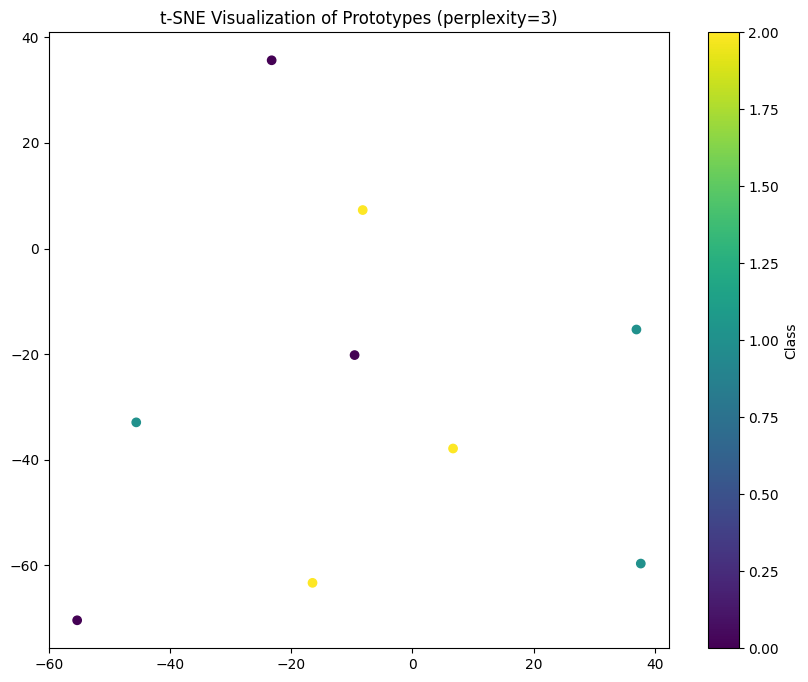

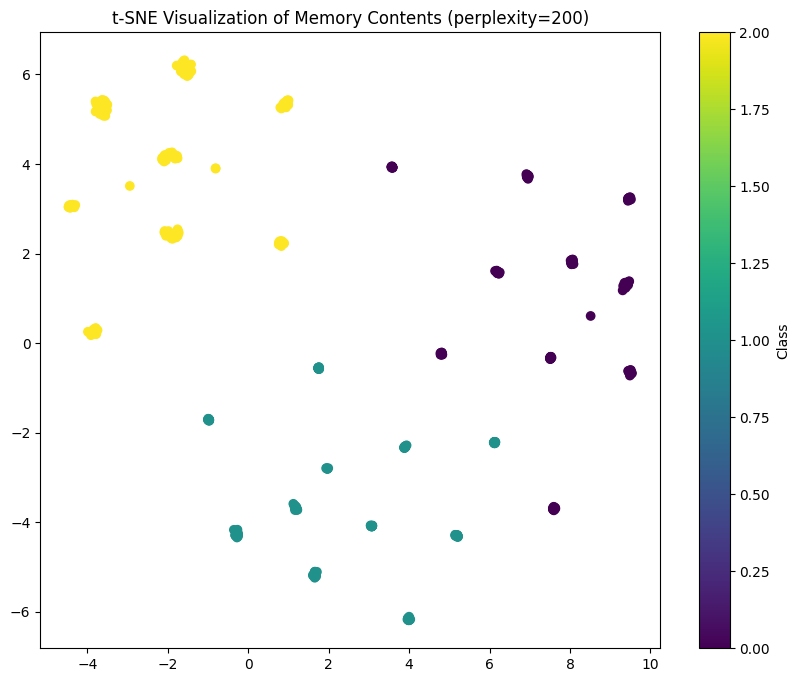

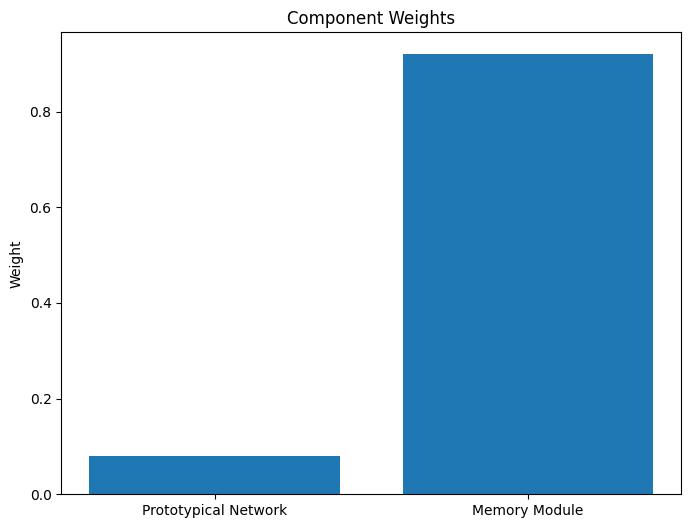

Training:  19%|▏| 200/1050 [04:24<15:00,  1.06s/it, Train Loss=16.3571, Train Acc=0.9375, Val Loss=1

Validation loss decreased (17.536733 --> 16.377989). Saving model ...
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([39766., 39816., 39836.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


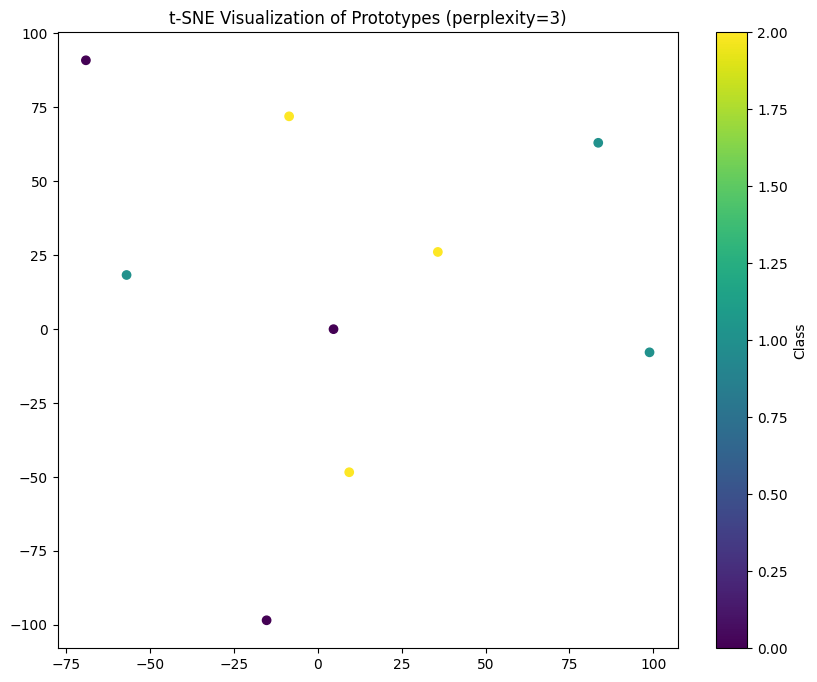

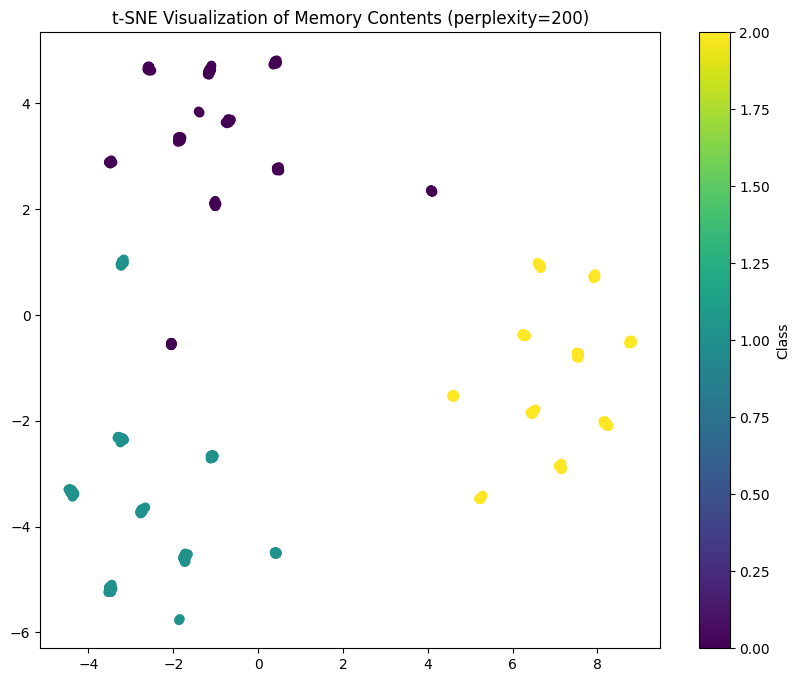

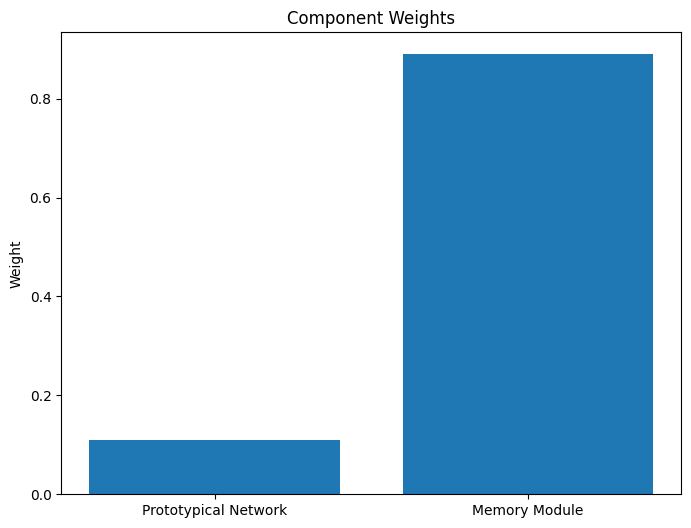

Training:  29%|▎| 300/1050 [06:41<14:50,  1.19s/it, Train Loss=15.4946, Train Acc=0.9375, Val Loss=1

Validation loss decreased (16.377989 --> 15.482737). Saving model ...
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([59702., 59754., 59784.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


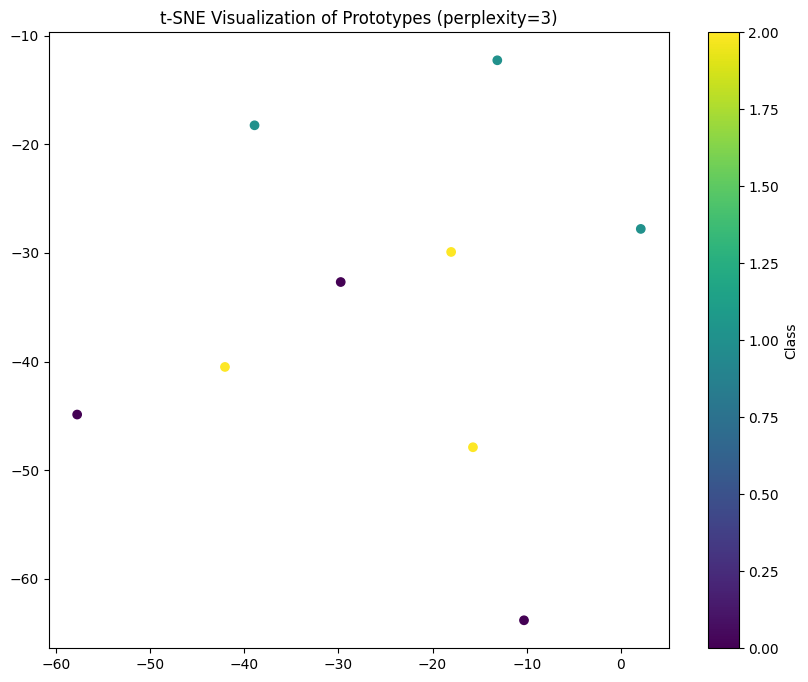

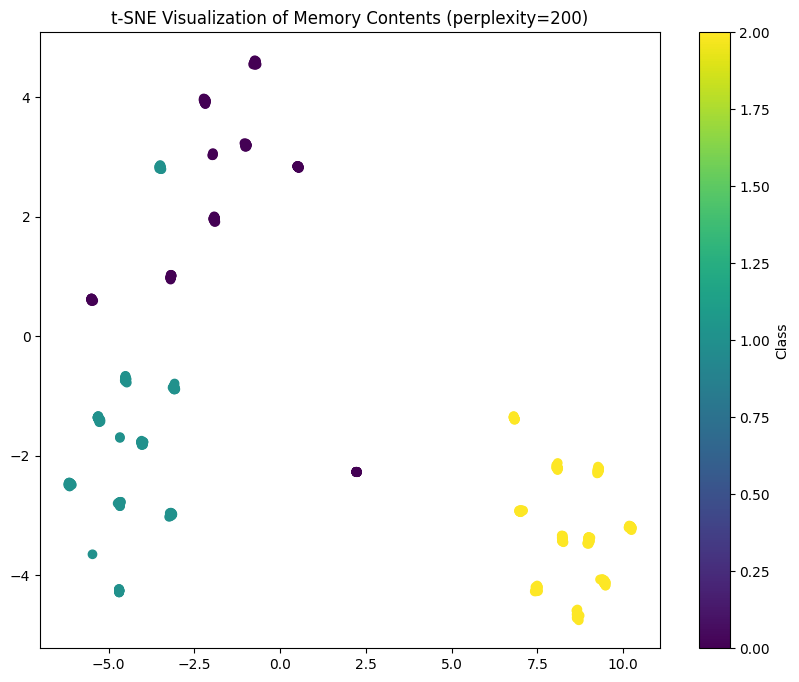

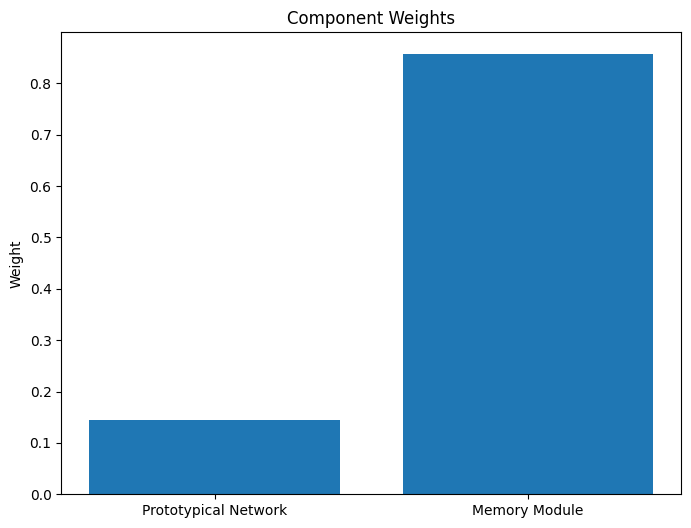

Training:  38%|▍| 400/1050 [08:57<10:29,  1.03it/s, Train Loss=14.8923, Train Acc=1.0000, Val Loss=1

Validation loss decreased (15.482737 --> 15.115366). Saving model ...
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([79642., 79712., 79726.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


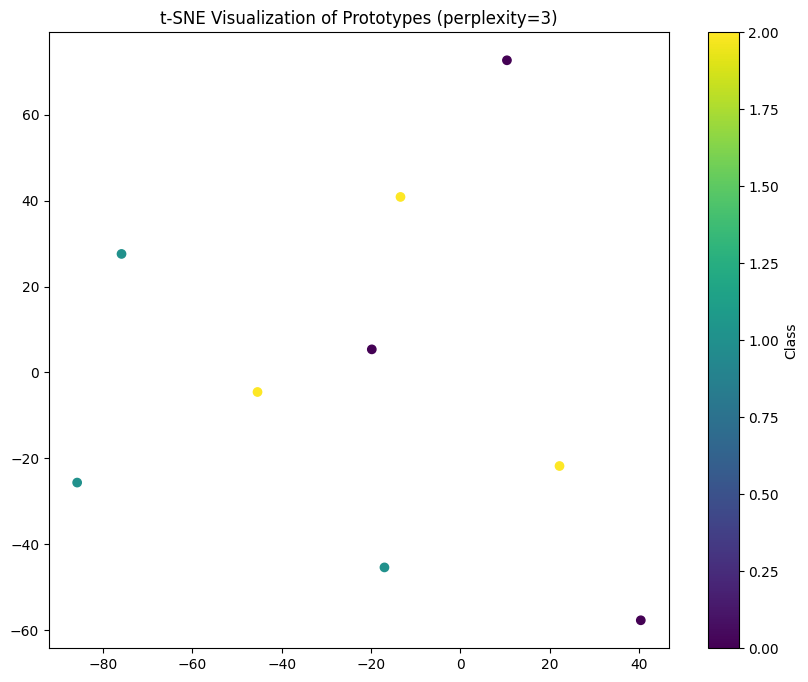

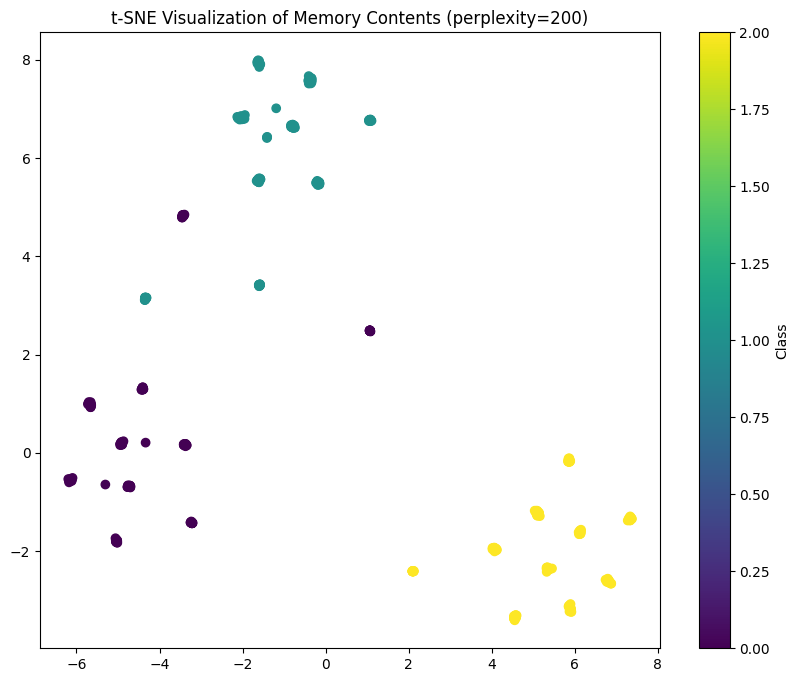

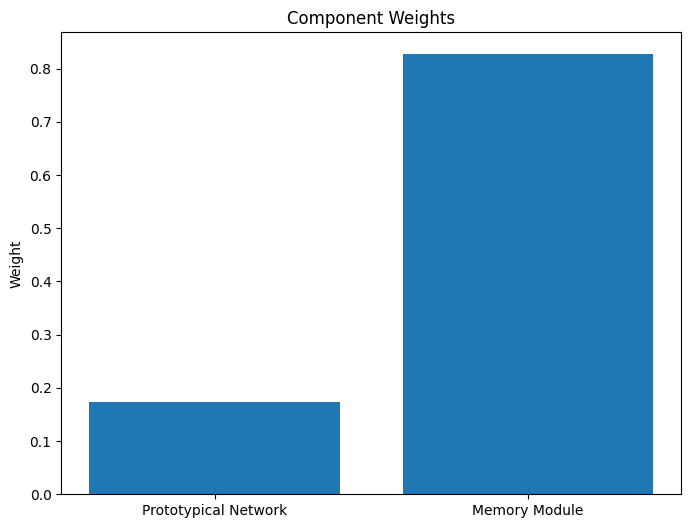

Training:  48%|▍| 500/1050 [11:09<08:49,  1.04it/s, Train Loss=14.4877, Train Acc=1.0000, Val Loss=1

Validation loss decreased (15.115366 --> 14.701318). Saving model ...
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([99606., 99658., 99674.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


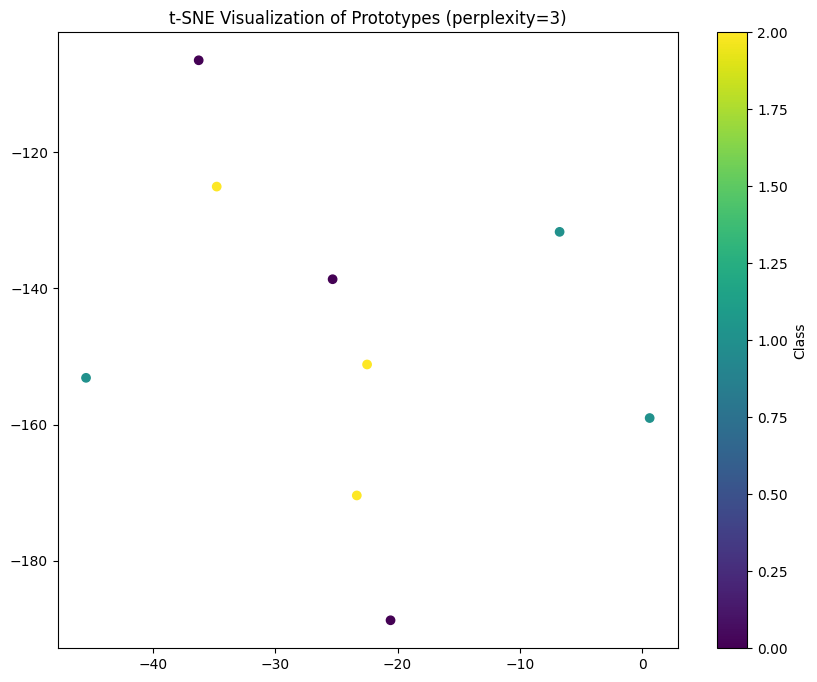

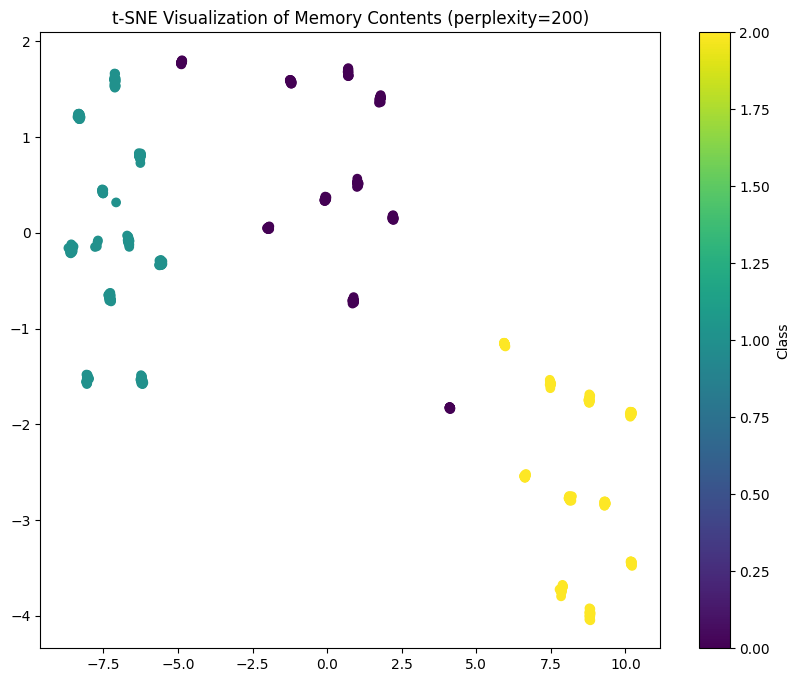

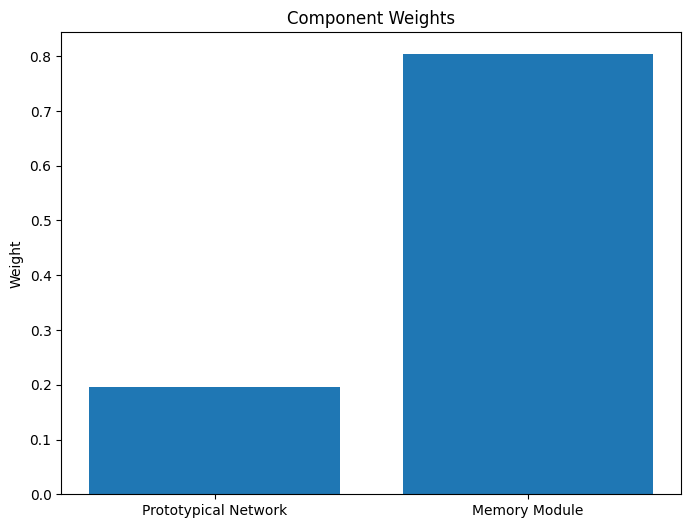

Training:  57%|▌| 600/1050 [13:29<07:48,  1.04s/it, Train Loss=14.1680, Train Acc=1.0000, Val Loss=1

Validation loss decreased (14.701318 --> 14.351680). Saving model ...
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([119556., 119608., 119628.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


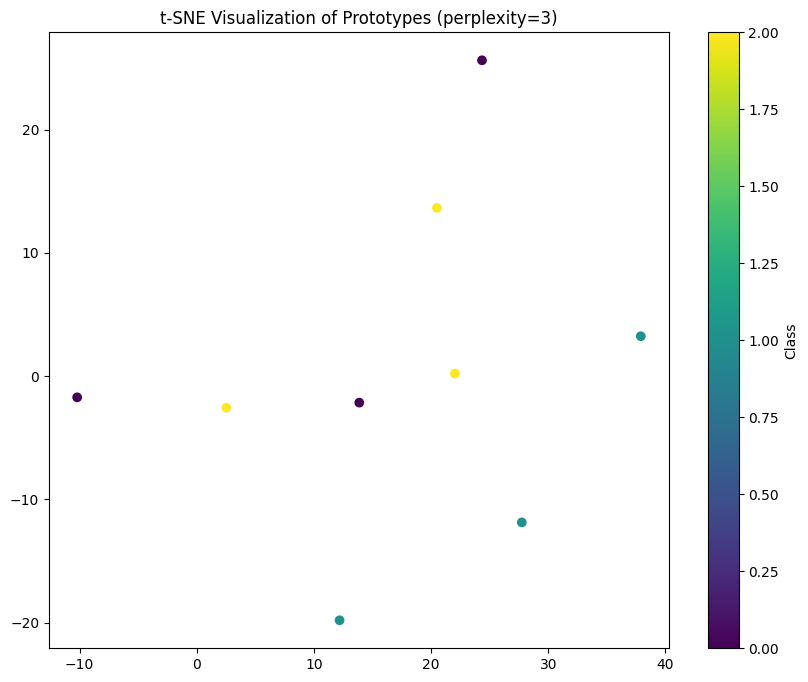

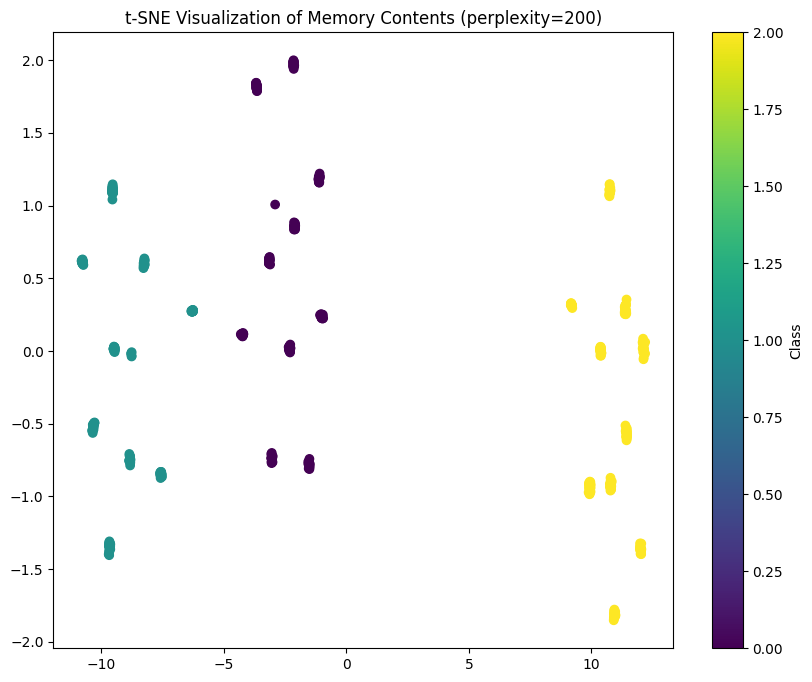

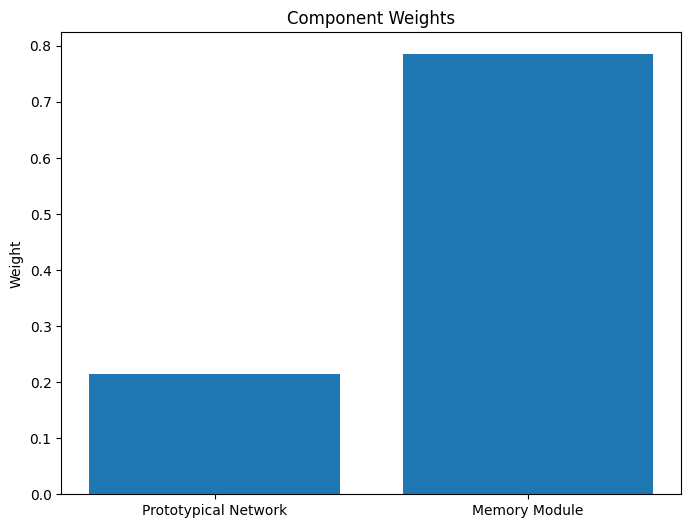

Training:  67%|▋| 700/1050 [15:48<06:23,  1.09s/it, Train Loss=13.9706, Train Acc=1.0000, Val Loss=1

Validation loss decreased (14.351680 --> 14.120184). Saving model ...
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([139500., 139546., 139584.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


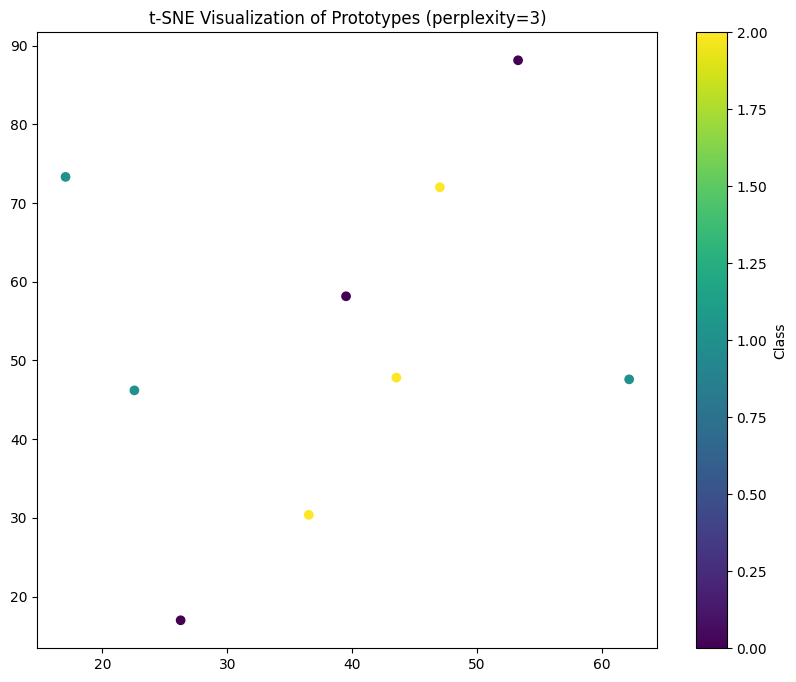

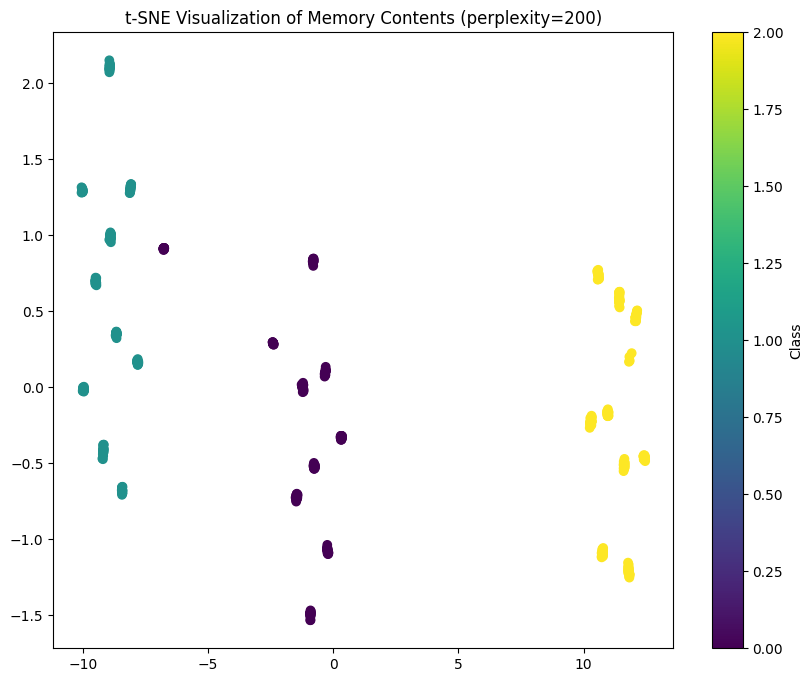

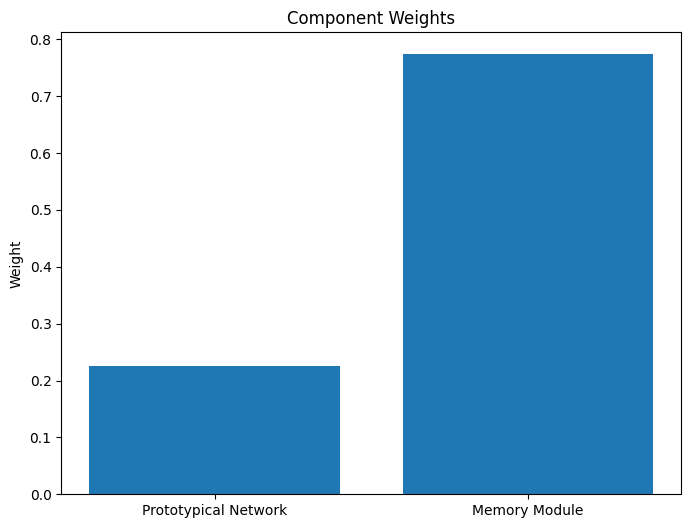

Training:  76%|▊| 800/1050 [18:08<04:55,  1.18s/it, Train Loss=14.2358, Train Acc=0.8750, Val Loss=1

Validation loss decreased (14.120184 --> 14.016830). Saving model ...
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([159464., 159480., 159548.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


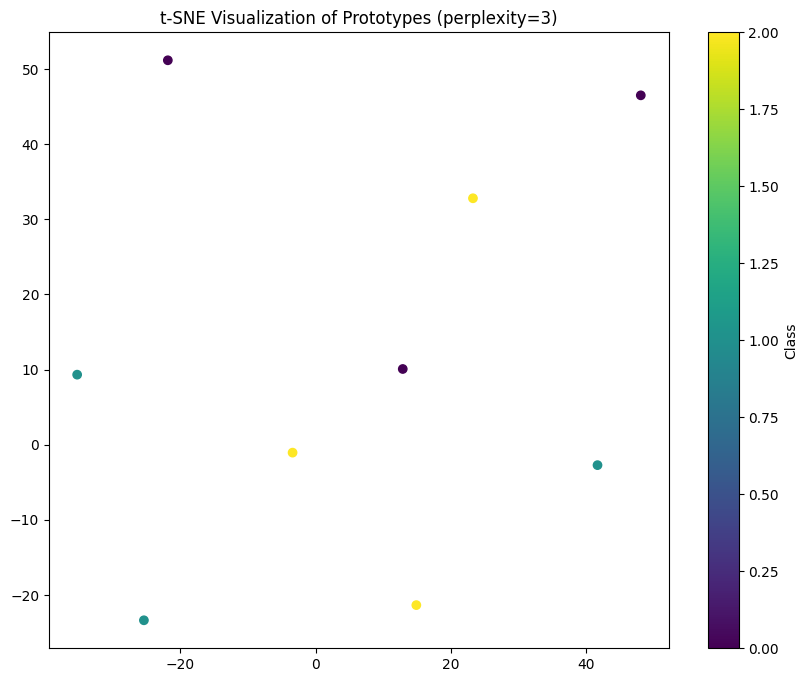

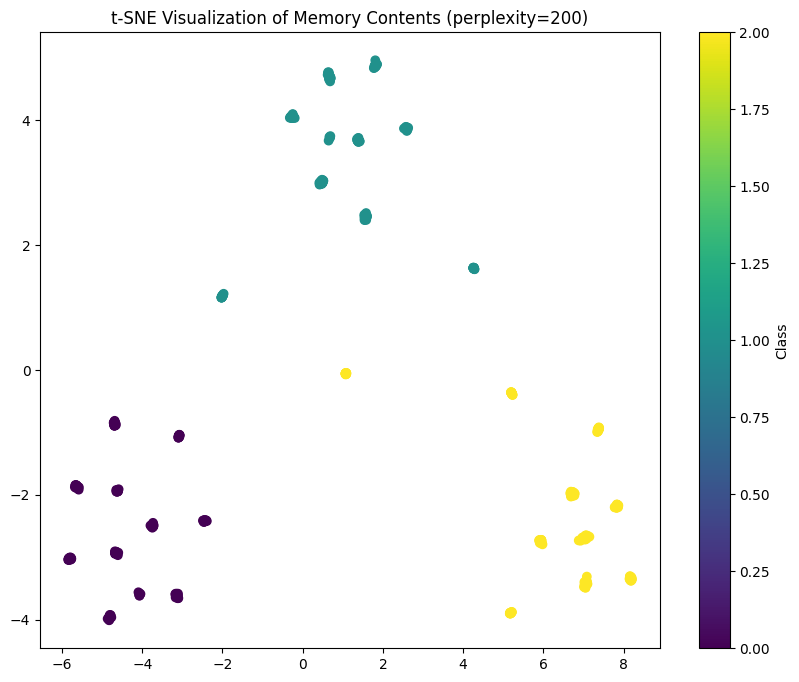

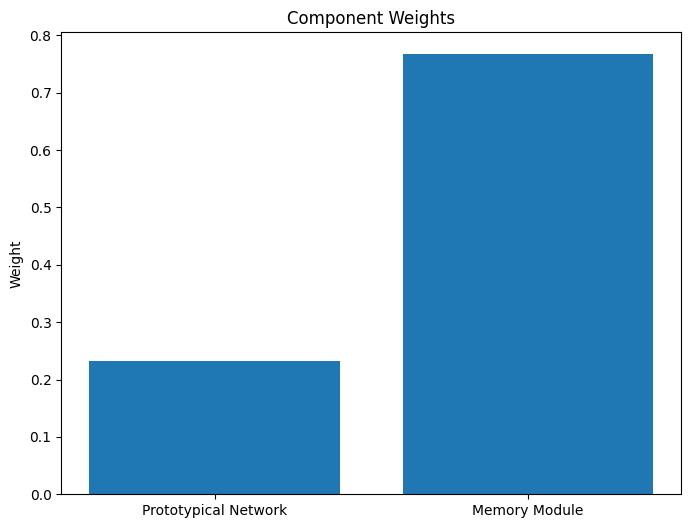

Training:  86%|▊| 900/1050 [20:27<02:37,  1.05s/it, Train Loss=13.7973, Train Acc=1.0000, Val Loss=1

Validation loss decreased (14.016830 --> 13.859321). Saving model ...
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([179414., 179422., 179508.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


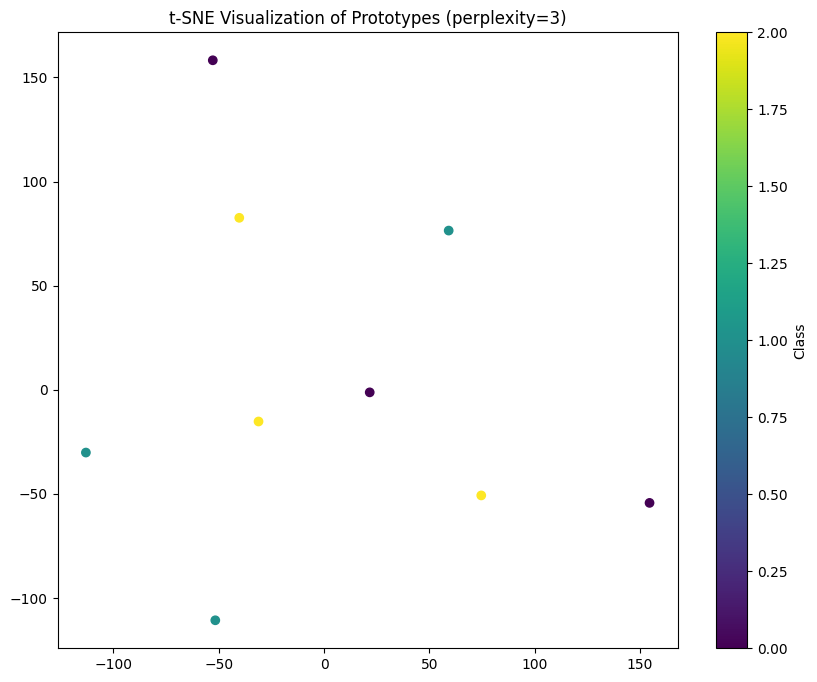

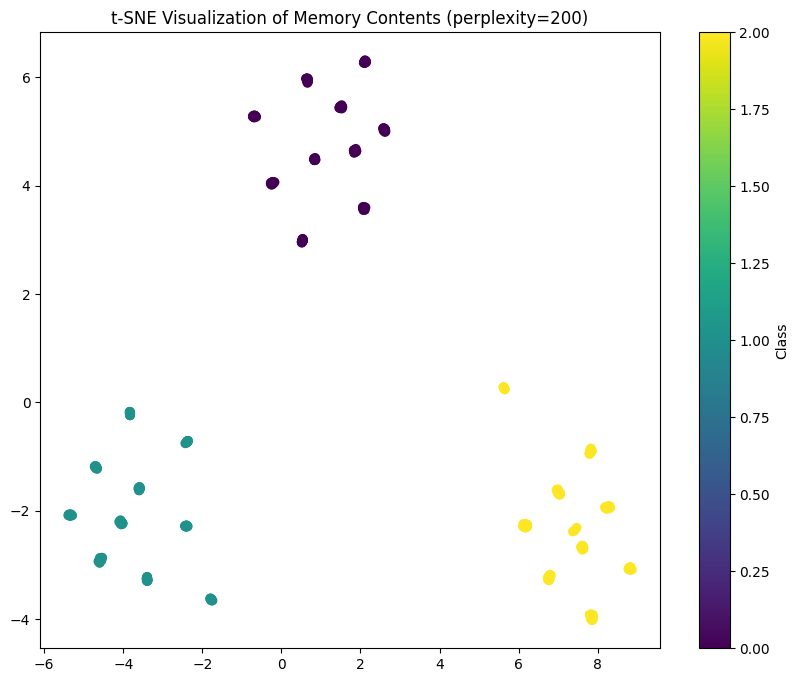

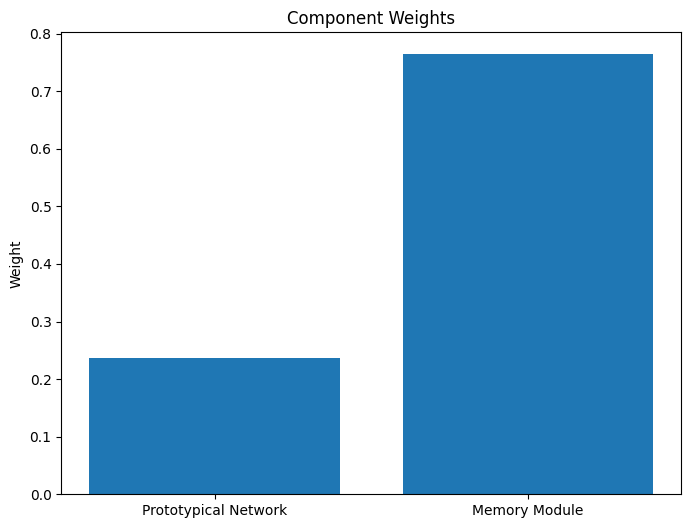

Training:  95%|▉| 1000/1050 [22:51<00:53,  1.07s/it, Train Loss=13.7804, Train Acc=1.0000, Val Loss=

EarlyStopping counter: 1 out of 10
Checking model balance:
Memory balance: tensor([[200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 200,  ..., 200, 200, 200],
        [200, 200, 199,  ..., 200, 200, 200]], device='cuda:0')
Total updates per class: tensor([199372., 199374., 199464.])
All classes have been updated in the memory.
Number of prototypes: 3
Prototype shapes: torch.Size([3, 3, 1280])


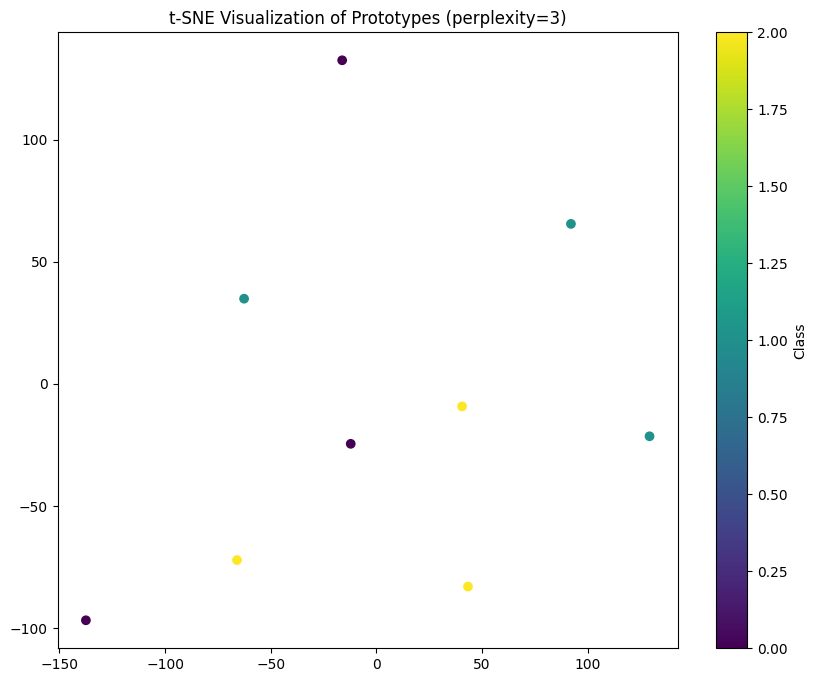

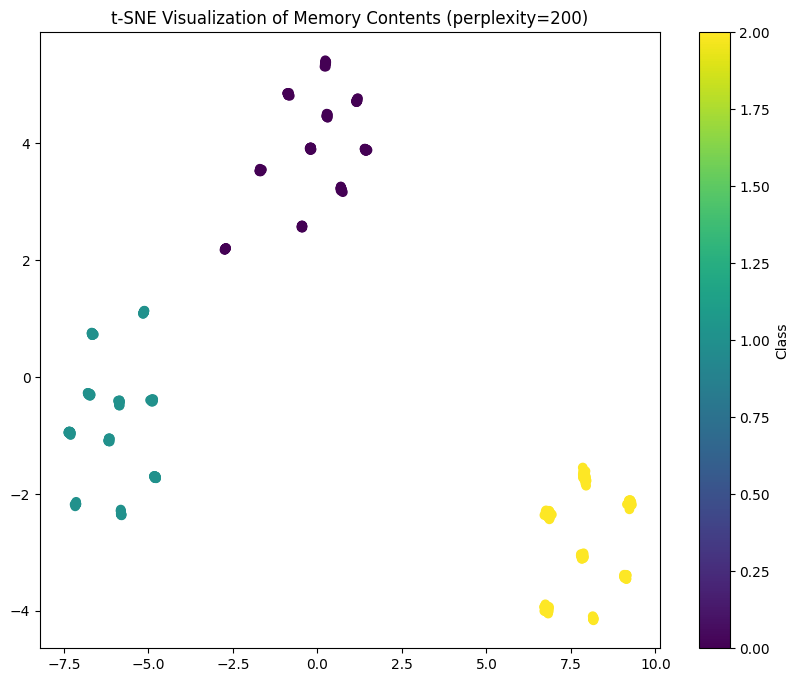

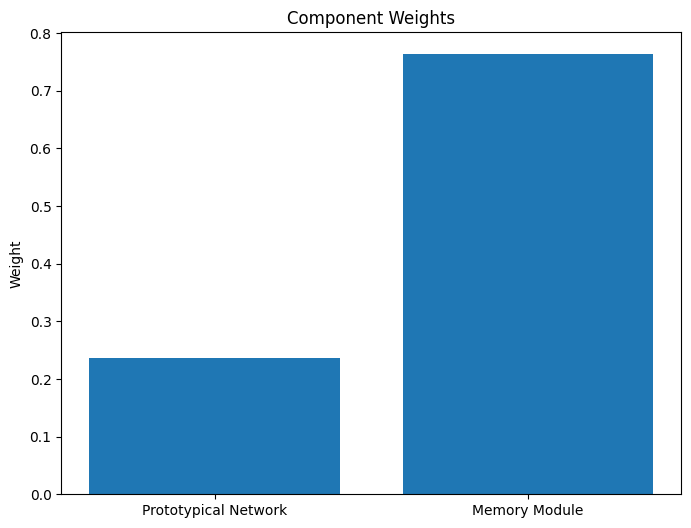

Training: 100%|█| 1050/1050 [24:14<00:00,  1.13s/it, Train Loss=14.0694, Train Acc=0.9375, Val Loss=

EarlyStopping counter: 2 out of 10


Training: 100%|█| 1050/1050 [24:14<00:00,  1.39s/it, Train Loss=14.0694, Train Acc=0.9375, Val Loss=



Final Evaluation on Test Set:


Testing: 100%|██████████| 225/225 [00:39<00:00,  5.65it/s]



Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3375
           1       1.00      1.00      1.00      3375
           2       1.00      0.94      0.97      3375

    accuracy                           0.98     10125
   macro avg       0.98      0.98      0.98     10125
weighted avg       0.98      0.98      0.98     10125


Test Set Confusion Matrix:


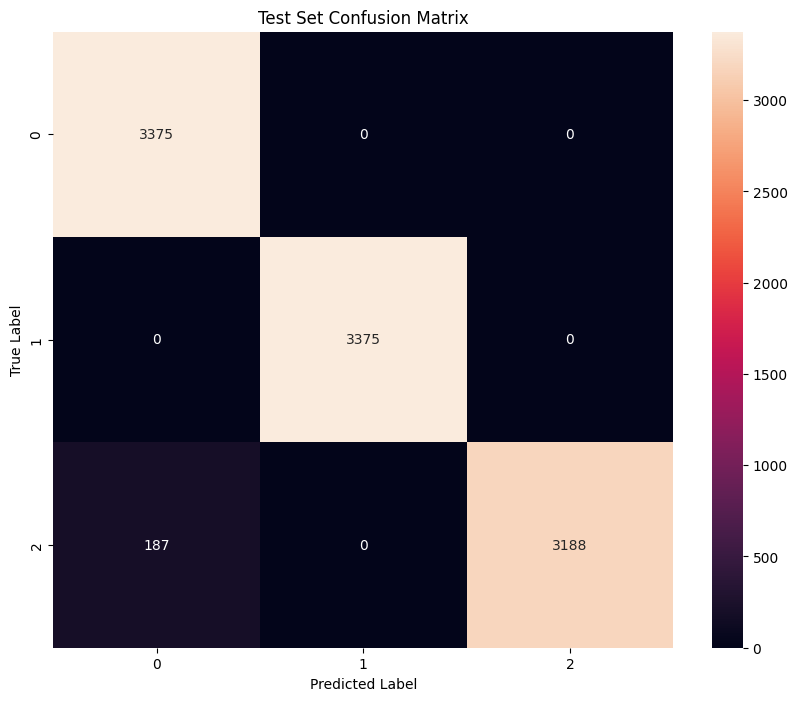

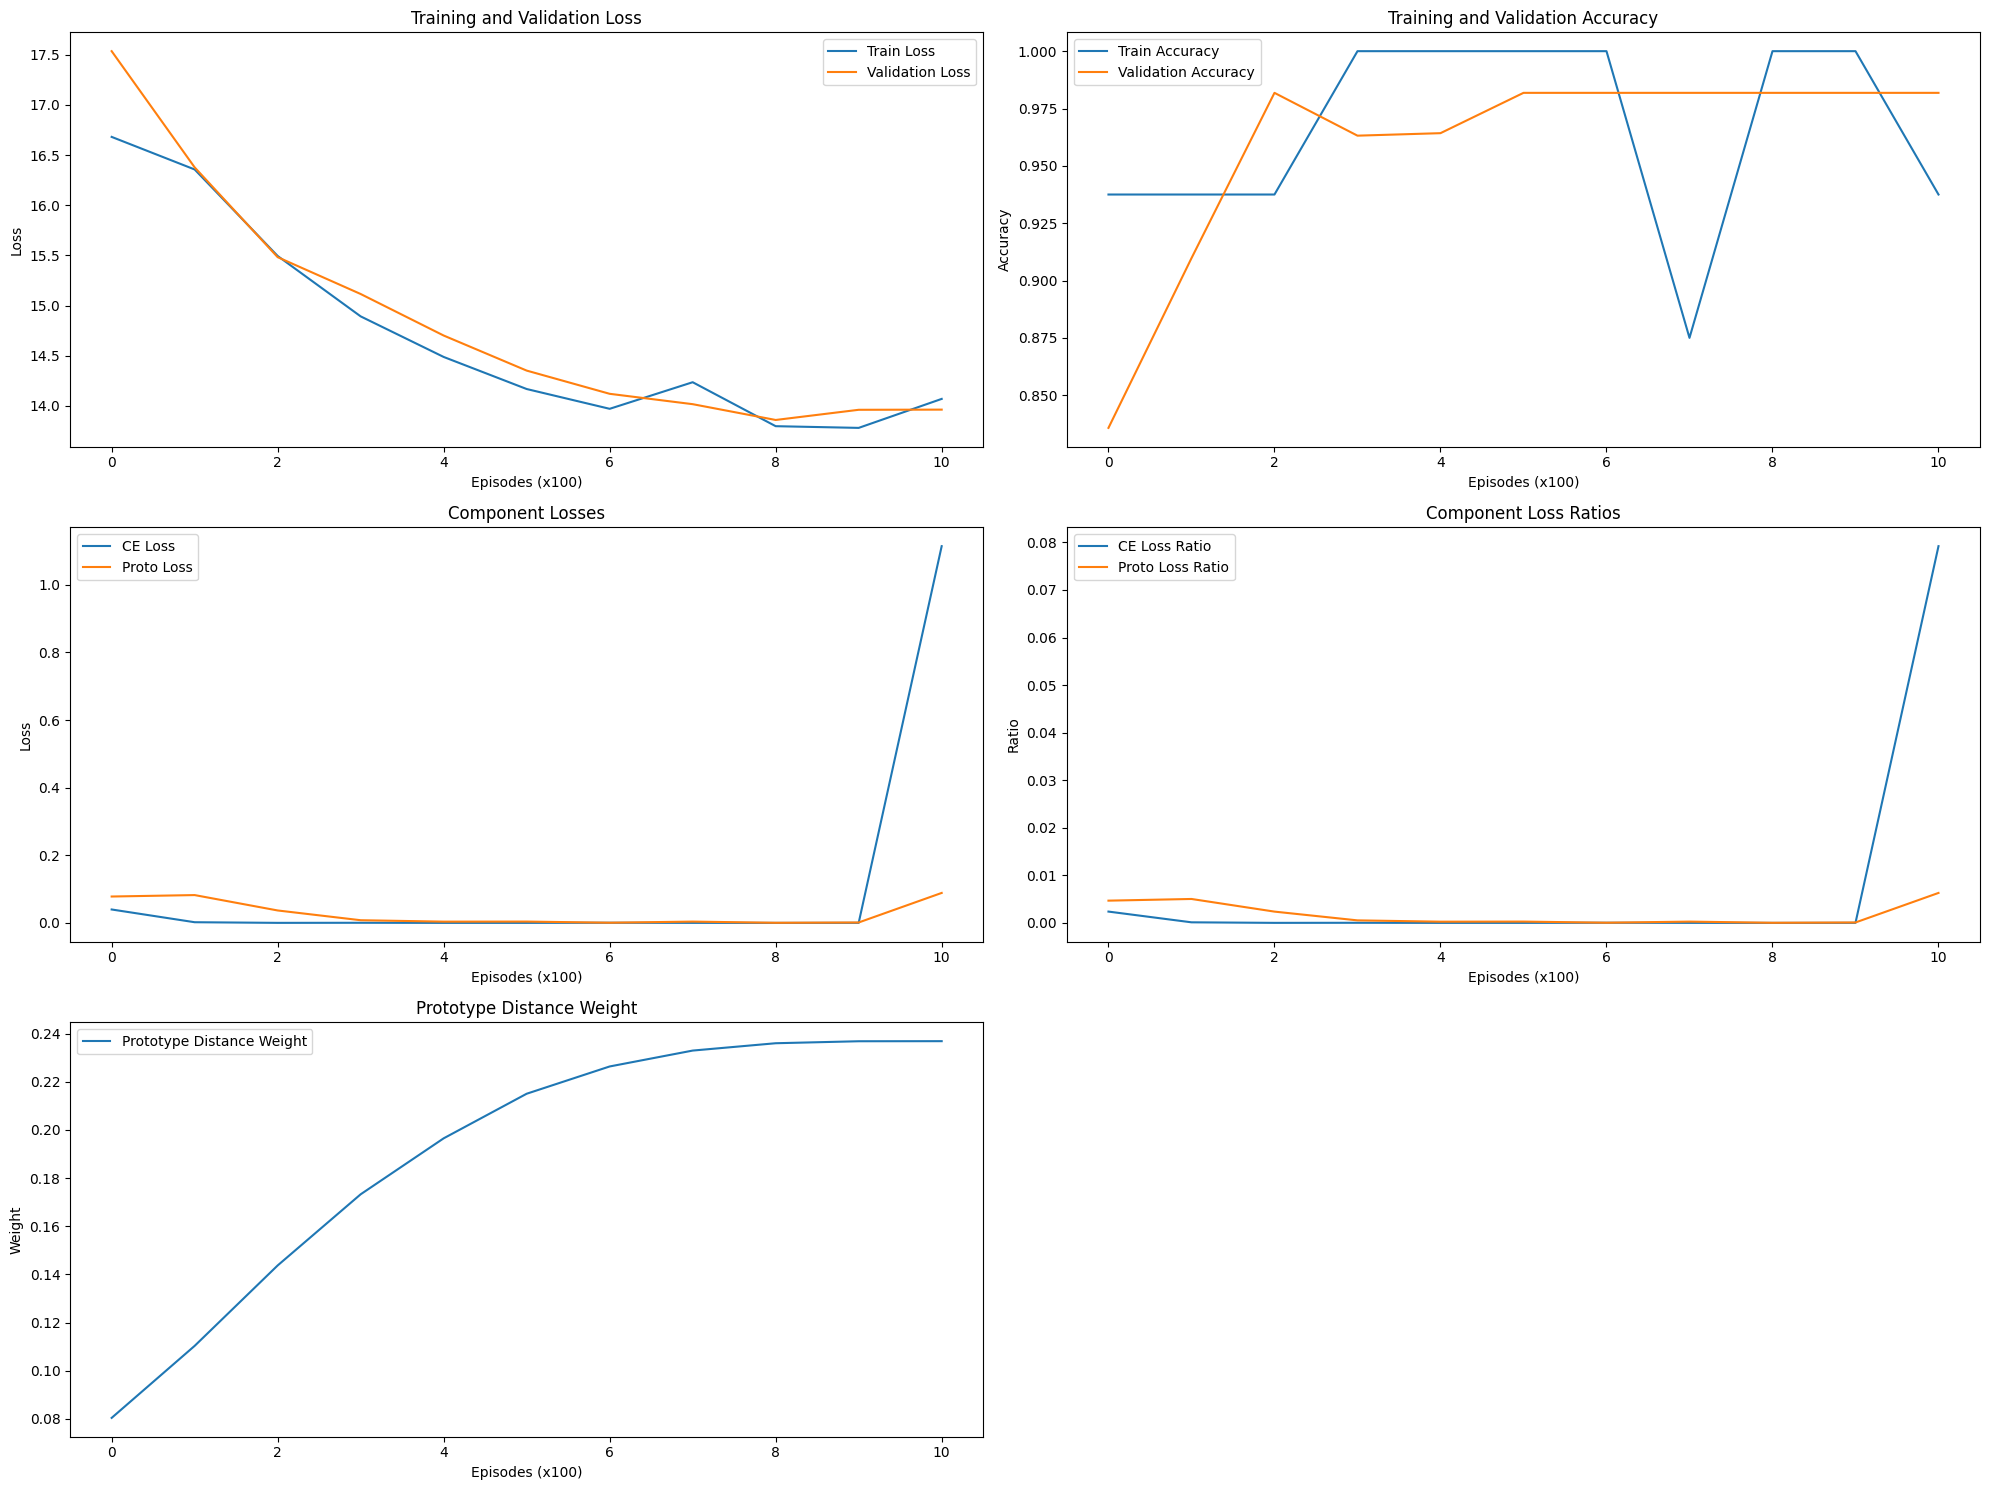


Generating final visualizations...


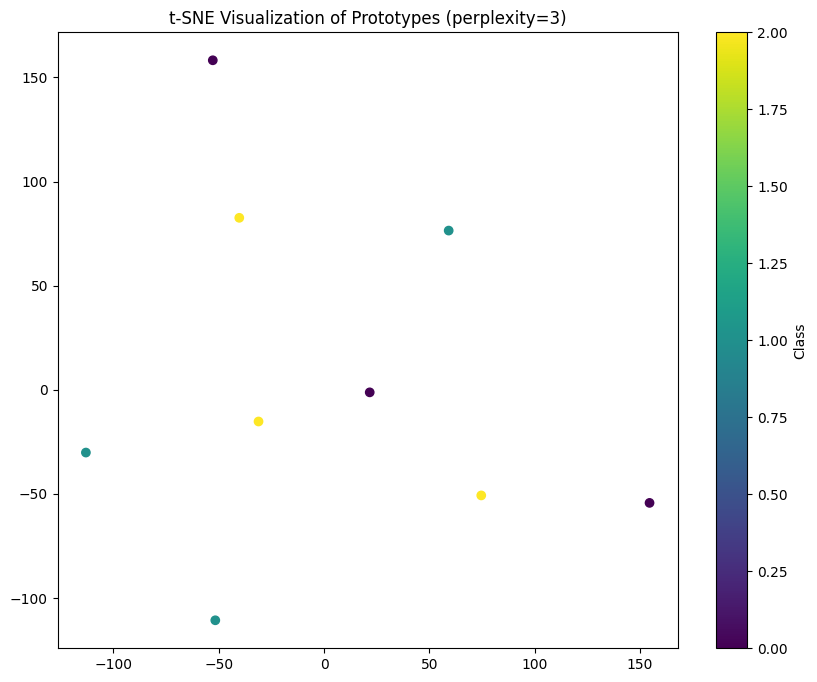

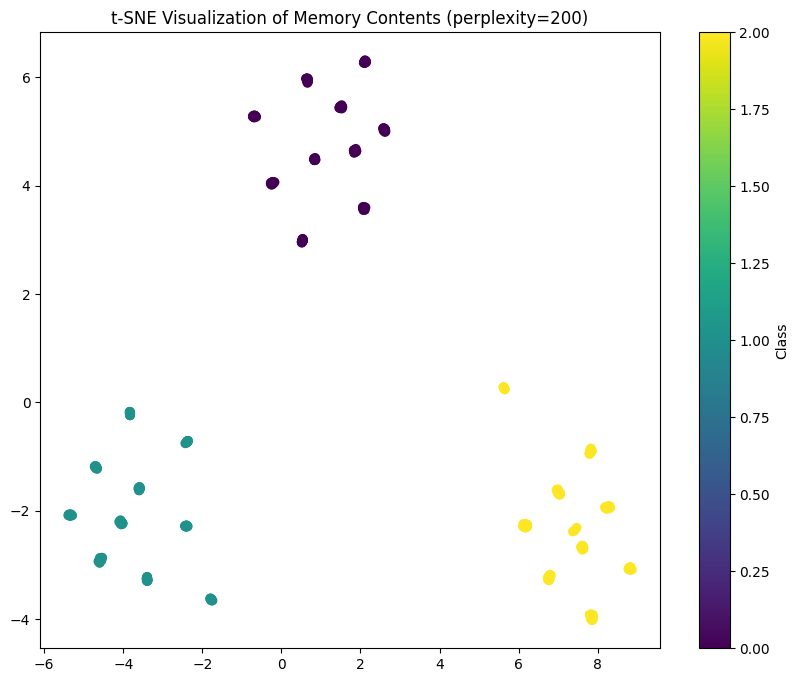

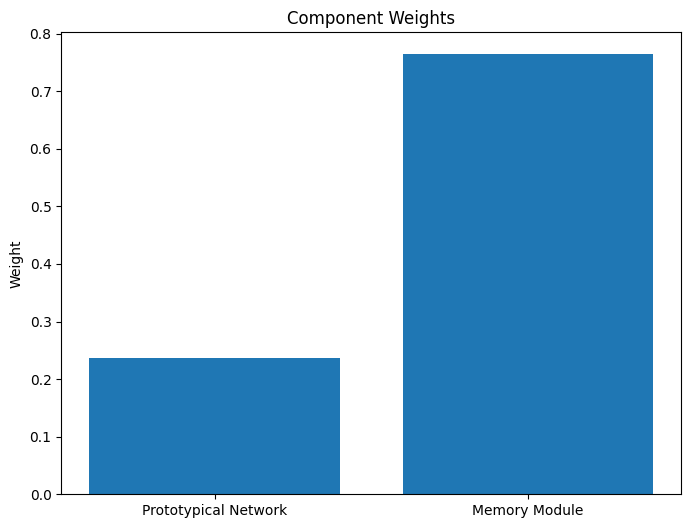


Generating final t-SNE visualization for test set...


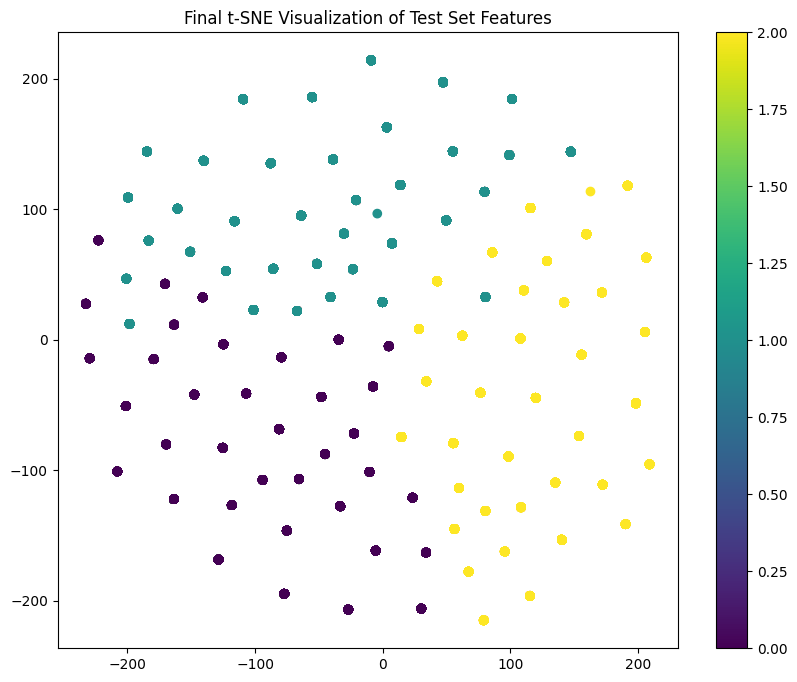

Training and evaluation completed.


In [2]:
class ImprovedDynamicFewShotClassifier(nn.Module):
    def __init__(self, n_way, feature_dim=1280, memory_size=200):
        super(ImprovedDynamicFewShotClassifier, self).__init__()
        self.n_way = n_way
        self.feature_dim = feature_dim
        
        # Load pre-trained EfficientNetB0
        efficientnet = models.efficientnet_b0(pretrained=True)
        
        # Remove the last fully connected layer
        self.feature_extractor = nn.Sequential(*list(efficientnet.children())[:-1])
        
        # Modify the first convolutional layer to accept 1-channel input
        self.feature_extractor[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        
        self.fc = nn.Sequential(
            nn.Linear(1280, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(feature_dim, feature_dim)
        )
        
        self.prototypical_network = HybridPrototypicalNetwork(feature_dim, num_prototypes=n_way, num_scales=3)
        self.memory_module = EnhancedMemoryModule(feature_dim, n_way, memory_size)
        
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim * 2 + n_way, feature_dim * 2),
            nn.LayerNorm(feature_dim * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(feature_dim * 2, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(feature_dim, n_way)
        )
        
        self.class_thresholds = nn.Parameter(torch.zeros(n_way))
        
        self.apply(self.init_weights)
        
        # Add L2 regularization
        self.l2_reg_strength = 0.01
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)
    
    def extract_features(self, x):
        if x.numel() == 0:
            return torch.empty(0, self.feature_dim, device=x.device)
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def forward(self, support_set, support_labels, query_set):
        if support_set.numel() == 0 or query_set.numel() == 0:
            return torch.empty(0), torch.empty(0), torch.empty(0)

        support_features = self.extract_features(support_set)
        query_features = self.extract_features(query_set)
        
        proto_logits, proto_reg = self.prototypical_network(support_features, support_labels, query_features)
        
        memory_output, memory_logits = self.memory_module(query_features)
        
        combined_features = torch.cat([query_features, memory_output, memory_logits], dim=-1)
        
        output = self.classifier(combined_features)
        
        output = output + self.class_thresholds
        
        # Add L2 regularization
        l2_reg = sum(torch.sum(param ** 2) for param in self.parameters())
        
        return output, proto_logits, proto_reg + self.l2_reg_strength * l2_reg
    
    def update_memory(self, features, labels):
        self.memory_module.update_memory(features, labels)

    def check_model_balance(self):
        print("Checking model balance:")
        self.memory_module.check_memory_balance()
        self.prototypical_network.check_prototypes()

    def save_model_with_memory(self, path):
        state_dict = self.state_dict()
        memory_state = {}
        self.memory_module.save_memory_state(memory_state)
        state = {
            'model_state_dict': state_dict,
            'memory_state': memory_state
        }
        torch.save(state, path)

    def load_model_with_memory(self, path):
        state = torch.load(path)
        self.load_state_dict(state['model_state_dict'])
        self.memory_module.load_memory_state(state['memory_state'])


class DynamicWeightScheduler:
    def __init__(self, initial_weight=0.1, min_weight=0.01, max_weight=0.5, decay_factor=0.99):
        self.weight = initial_weight
        self.min_weight = min_weight
        self.max_weight = max_weight
        self.decay_factor = decay_factor

    def step(self, val_loss):
        self.weight = max(self.min_weight, min(self.max_weight, self.weight * self.decay_factor))
        return self.weight

def check_nan_inf(tensor, tensor_name):
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        print(f"NaN or Inf detected in {tensor_name}")
        return True
    return False

def train_episode(model, optimizer, support_set, support_labels, query_set, query_labels, 
                  device, criterion, proto_weight, accumulation_steps=4):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    
    all_predictions = []
    all_labels = []
    correct_features = []
    correct_labels = []
    
    for i in range(0, len(query_set), accumulation_steps):
        batch_support = support_set[i:i+accumulation_steps]
        batch_support_labels = support_labels[i:i+accumulation_steps]
        batch_query = query_set[i:i+accumulation_steps]
        batch_query_labels = query_labels[i:i+accumulation_steps]
        
        if batch_support.numel() == 0 or batch_query.numel() == 0:
            continue
        
        output, proto_logits, proto_reg = model(batch_support, batch_support_labels, batch_query)
        
        if check_nan_inf(output, "output") or check_nan_inf(proto_logits, "proto_logits") or \
           check_nan_inf(proto_reg, "proto_reg"):
            print("NaN or Inf detected, skipping this batch")
            continue
        
        ce_loss = criterion(output, batch_query_labels)
        proto_loss = proto_weight * criterion(proto_logits, batch_query_labels)
        
        loss = ce_loss + 0.5 * proto_loss + 0.01 * proto_reg
        loss = loss / accumulation_steps
        
        if not torch.isfinite(loss):
            print(f"Non-finite loss detected: {loss.item()}")
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        total_loss += loss.item()

        with torch.no_grad():
            batch_predictions = torch.argmax(output, dim=1)
            all_predictions.append(batch_predictions)
            all_labels.append(batch_query_labels)
            
            correct_mask = (batch_predictions == batch_query_labels)
            if correct_mask.sum() > 0:
                correct_features.append(model.extract_features(batch_query[correct_mask]))
                correct_labels.append(batch_query_labels[correct_mask])
    
    if len(all_predictions) > 0:
        optimizer.step()
        
        all_predictions = torch.cat(all_predictions)
        all_labels = torch.cat(all_labels)
        
        if len(correct_features) > 0:
            correct_features = torch.cat(correct_features)
            correct_labels = torch.cat(correct_labels)
            
            combined_features = torch.cat([model.extract_features(support_set), correct_features])
            combined_labels = torch.cat([support_labels, correct_labels])
            model.update_memory(combined_features, combined_labels)
        
        accuracy = (all_predictions == all_labels).float().mean().item()
        
        memory_info = model.memory_module.get_update_info()
        
        return total_loss, accuracy, {
            'ce_loss': ce_loss.item(),
            'proto_loss': proto_loss.item(),
            'proto_reg': proto_reg.item(),
            'memory_updates': memory_info['total_updates'],
            'class_balance': memory_info['class_balance_weights']
        }
    else:
        print("No valid batches in this episode")
        return 0.0, 0.0, {
            'ce_loss': 0.0,
            'proto_loss': 0.0,
            'proto_reg': 0.0,
            'memory_updates': 0,
            'class_balance': [0] * model.n_way
        }

@torch.no_grad()
def evaluate_episode(model, support_set, support_labels, query_set, query_labels, device, criterion, proto_weight):
    model.eval()
    output, proto_logits, proto_reg = model(support_set, support_labels, query_set)
    
    ce_loss = criterion(output, query_labels)
    proto_loss = proto_weight * criterion(proto_logits, query_labels)
    
    loss = ce_loss + 0.5 * proto_loss + 0.01 * proto_reg
    
    predictions = torch.argmax(output, dim=1)
    accuracy = (predictions == query_labels).float().mean()
    
    return {
        'loss': loss.item(),
        'accuracy': accuracy.item(),
        'predictions': predictions.cpu().numpy(),
        'true_labels': query_labels.cpu().numpy(),
        'ce_loss': ce_loss.item(),
        'proto_loss': proto_loss.item(),
        'proto_reg': proto_reg.item()
    }

class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.001, path='best_model_with_memory.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        model.save_model_with_memory(self.path)  
        self.val_loss_min = val_loss

def visualize_prototypes(model):
    prototypes = model.prototypical_network.prototype_vectors.detach().cpu().numpy()
    prototypes_flat = prototypes.reshape(-1, prototypes.shape[-1])
    
    n_samples = prototypes_flat.shape[0]
    perplexity = max(2, min(n_samples - 1, n_samples // 3))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    embedded_prototypes = tsne.fit_transform(prototypes_flat)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedded_prototypes[:, 0], embedded_prototypes[:, 1], 
                          c=np.repeat(np.arange(prototypes.shape[1]), prototypes.shape[0]), 
                          cmap='viridis')
    plt.colorbar(scatter, label='Class')
    plt.title(f't-SNE Visualization of Prototypes (perplexity={perplexity})')
    plt.show('prototype_visualization')
    plt.close()

def visualize_memory_contents(model):
    memory_contents = model.memory_module.memory.detach().cpu().numpy()
    memory_flat = memory_contents.reshape(-1, memory_contents.shape[-1])
    
    n_samples = memory_flat.shape[0]
    perplexity = max(2, min(n_samples - 1, n_samples // 3))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    embedded_memory = tsne.fit_transform(memory_flat)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embedded_memory[:, 0], embedded_memory[:, 1], 
                          c=np.repeat(np.arange(memory_contents.shape[0]), memory_contents.shape[1]), 
                          cmap='viridis')
    plt.colorbar(scatter, label='Class')
    plt.title(f't-SNE Visualization of Memory Contents (perplexity={perplexity})')
    plt.show('memory_visualization')
    plt.close()

def analyze_component_weights(model):
    proto_weight = model.prototypical_network.prototype_distance_weight.item()
    memory_weight = 1 - proto_weight  
    
    plt.figure(figsize=(8, 6))
    plt.bar(['Prototypical Network', 'Memory Module'], [proto_weight, memory_weight])
    plt.title('Component Weights')
    plt.ylabel('Weight')
    plt.show()
    plt.close()
        
def main(episodes_path, num_episodes_to_load, feature_dim=1280, memory_size=200, learning_rate=0.0003):
    print("Starting improved few-shot learning process")
    print(f"Episodes path: {episodes_path}")
    print(f"Number of episodes to load: {num_episodes_to_load}")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    with h5py.File(episodes_path, 'r') as hf:
        episodes_group = hf['episodes']
        all_episode_keys = list(episodes_group.keys())
        
        selected_episode_keys = random.sample(all_episode_keys, num_episodes_to_load)
        
        print(f"Loaded {num_episodes_to_load} episodes")

        first_episode = episodes_group[selected_episode_keys[0]]
        n_way = len(np.unique(first_episode['support_labels'][()]))
        print(f"n_way: {n_way}")

        model = ImprovedDynamicFewShotClassifier(n_way=n_way, feature_dim=feature_dim, memory_size=memory_size).to(device)

        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
        criterion = nn.CrossEntropyLoss().to(device)
        proto_weight_scheduler = DynamicWeightScheduler(initial_weight=0.1, min_weight=0.05, max_weight=0.5, decay_factor=0.99)

        np.random.shuffle(selected_episode_keys)
        train_split = int(0.7 * len(selected_episode_keys))
        val_split = int(0.85 * len(selected_episode_keys))
        train_episodes = selected_episode_keys[:train_split]
        val_episodes = selected_episode_keys[train_split:val_split]
        test_episodes = selected_episode_keys[val_split:]

        print(f"Number of training episodes: {len(train_episodes)}")
        print(f"Number of validation episodes: {len(val_episodes)}")
        print(f"Number of test episodes: {len(test_episodes)}")

        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=len(train_episodes), T_mult=2)

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        ce_losses = []
        proto_losses = []
        component_weights = []

        early_stopping = EarlyStopping(patience=10, verbose=True, path='best_model_with_memory.pt')

        with tqdm(total=len(train_episodes), desc="Training", ncols=100) as progress_bar:
            for episode_idx, train_episode_key in enumerate(train_episodes):
                train_episode_data = episodes_group[train_episode_key]

                support_batch = torch.from_numpy(train_episode_data['support_data'][()]).float().to(device)
                support_labels = torch.from_numpy(train_episode_data['support_labels'][()]).long().to(device)
                query_batch = torch.from_numpy(train_episode_data['query_data'][()]).float().to(device)
                query_labels = torch.from_numpy(train_episode_data['query_labels'][()]).long().to(device)

                train_loss, train_accuracy, loss_components = train_episode(
                    model, optimizer, support_batch, support_labels, query_batch, query_labels,
                    device, criterion, proto_weight_scheduler.weight
                )
            
                scheduler.step()
            
                progress_bar.update(1)
                progress_bar.set_postfix({
                    'L': f'{train_loss:.3f}',
                    'A': f'{train_accuracy:.2f}',
                    'M': loss_components['memory_updates'],
                    'C': f"{[f'{w:.2f}' for w in loss_components['class_balance']]}"
                })

                if (episode_idx + 1) % 100 == 0 or episode_idx == len(train_episodes) - 1:
                    val_losses_100 = []
                    val_accuracies_100 = []
                    for val_episode_key in val_episodes:
                        val_episode_data = episodes_group[val_episode_key]
                        val_support_batch = torch.from_numpy(val_episode_data['support_data'][()]).float().to(device)
                        val_support_labels = torch.from_numpy(val_episode_data['support_labels'][()]).long().to(device)
                        val_query_batch = torch.from_numpy(val_episode_data['query_data'][()]).float().to(device)
                        val_query_labels = torch.from_numpy(val_episode_data['query_labels'][()]).long().to(device)

                        val_metrics = evaluate_episode(model, val_support_batch, val_support_labels, val_query_batch, val_query_labels, device, criterion, proto_weight_scheduler.weight)
                        val_losses_100.append(val_metrics['loss'])
                        val_accuracies_100.append(val_metrics['accuracy'])
                    
                    avg_val_loss = np.mean(val_losses_100)
                    avg_val_accuracy = np.mean(val_accuracies_100)
                    
                    proto_weight_scheduler.step(avg_val_loss)
                    
                    train_losses.append(train_loss)
                    train_accuracies.append(train_accuracy)
                    val_losses.append(avg_val_loss)
                    val_accuracies.append(avg_val_accuracy)
                    ce_losses.append(loss_components['ce_loss'])
                    proto_losses.append(loss_components['proto_loss'])
                    component_weights.append(model.prototypical_network.prototype_distance_weight.item())

                    progress_bar.set_postfix({
                        'Train Loss': f'{train_loss:.4f}',
                        'Train Acc': f'{train_accuracy:.4f}',
                        'Val Loss': f'{avg_val_loss:.4f}',
                        'Val Acc': f'{avg_val_accuracy:.4f}'
                    })

                    early_stopping(avg_val_loss, model)
                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

                    # Save checkpoint
                    model.save_model_with_memory(f'/kaggle/working/checkpoint_episode_{episode_idx+1}.pt')

                if (episode_idx + 1) % 100 == 0:
                    model.check_model_balance()
                    visualize_prototypes(model)
                    visualize_memory_contents(model)
                    analyze_component_weights(model)

        # Load the best model (saved by EarlyStopping)
        model.load_model_with_memory('best_model_with_memory.pt')

        # Save the final model with memory
        model.save_model_with_memory('/kaggle/working/final_model_with_memory.pt')

        print("\nFinal Evaluation on Test Set:")
        all_test_predictions = []
        all_test_true_labels = []
        all_test_features = []
        all_test_support_features = []
        all_test_support_labels = []

        for test_episode_key in tqdm(test_episodes, desc="Testing"):
            test_episode_data = episodes_group[test_episode_key]
            test_support_batch = torch.from_numpy(test_episode_data['support_data'][()]).float().to(device)
            test_support_labels = torch.from_numpy(test_episode_data['support_labels'][()]).long().to(device)
            test_query_batch = torch.from_numpy(test_episode_data['query_data'][()]).float().to(device)
            test_query_labels = torch.from_numpy(test_episode_data['query_labels'][()]).long().to(device)

            test_metrics = evaluate_episode(model, test_support_batch, test_support_labels, test_query_batch, test_query_labels, device, criterion, proto_weight_scheduler.weight)
            all_test_predictions.append(torch.tensor(test_metrics['predictions']).to(device))
            all_test_true_labels.append(test_query_labels)
            
            with torch.no_grad():
                output, proto_logits, proto_reg = model(test_support_batch, test_support_labels, test_query_batch)
                test_features = model.extract_features(test_query_batch)
                test_support_features = model.extract_features(test_support_batch)
            all_test_features.append(test_features)
            all_test_support_features.append(test_support_features)
            all_test_support_labels.append(test_support_labels)

        all_test_predictions = torch.cat(all_test_predictions)
        all_test_true_labels = torch.cat(all_test_true_labels)
        all_test_features = torch.cat(all_test_features, dim=0)
        all_test_support_features = torch.cat(all_test_support_features, dim=0)
        all_test_support_labels = torch.cat(all_test_support_labels)

        print("\nTest Set Classification Report:")
        print(classification_report(all_test_true_labels.cpu().numpy(), all_test_predictions.cpu().numpy()))

        print("\nTest Set Confusion Matrix:")
        cm = confusion_matrix(all_test_true_labels.cpu().numpy(), all_test_predictions.cpu().numpy())
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title('Test Set Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show('/kaggle/working/confusion_matrix')
        plt.close()

        plot_training_progress(train_losses, train_accuracies, val_losses, val_accuracies, ce_losses, proto_losses, component_weights)

        print("\nGenerating final visualizations...")
        visualize_prototypes(model)
        visualize_memory_contents(model)
        analyze_component_weights(model)

        print("\nGenerating final t-SNE visualization for test set...")
        all_features = torch.cat([all_test_support_features, all_test_features], dim=0)
        all_labels = torch.cat([all_test_support_labels, all_test_true_labels])
        
        tsne = TSNE(n_components=2, random_state=42)
        embedded_features = tsne.fit_transform(all_features.cpu().numpy())

        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=all_labels.cpu().numpy(), cmap='viridis')
        plt.colorbar(scatter)
        plt.title('Final t-SNE Visualization of Test Set Features')
        plt.show('/kaggle/working/tsne_visualization.')
        plt.close()

        print("Training and evaluation completed.")
 
# Training Plots
def plot_training_progress(train_losses, train_accuracies, val_losses, val_accuracies, ce_losses, proto_losses, component_weights):
    plt.figure(figsize=(20, 15))
    
    plt.subplot(3, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Episodes (x100)')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Episodes (x100)')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 2, 3)
    plt.plot(ce_losses, label='CE Loss')
    plt.plot(proto_losses, label='Proto Loss')
    plt.title('Component Losses')
    plt.xlabel('Episodes (x100)')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(np.array(ce_losses) / np.array(train_losses), label='CE Loss Ratio')
    plt.plot(np.array(proto_losses) / np.array(train_losses), label='Proto Loss Ratio')
    plt.title('Component Loss Ratios')
    plt.xlabel('Episodes (x100)')
    plt.ylabel('Ratio')
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(component_weights, label='Prototype Distance Weight')
    plt.title('Prototype Distance Weight')
    plt.xlabel('Episodes (x100)')
    plt.ylabel('Weight')
    plt.legend()

    plt.tight_layout()
    plt.show('/kaggle/working/training_progress')
    plt.close()

if __name__ == "__main__":
    episodes_path = '/kaggle/working/dataset.h5'
    num_episodes_to_load = 1500
    feature_dim = 1280  
    memory_size = 200
    learning_rate = 0.0003

    main(episodes_path, num_episodes_to_load, feature_dim, memory_size, learning_rate)

# support file Creation for transductive inference

In [3]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import os
import random
import torch
import torchaudio
import h5py
import random
import os
import numpy as np
from tqdm import tqdm

class AudioDataset(Dataset):
    def __init__(self, root_dir, folder_names):
        self.root_dir = root_dir
        self.folder_names = folder_names
        self.files = []
        self.labels = []
        self.class_names = sorted(folder_names)
        
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_fft=1024,
            hop_length=512,
            n_mels=64
        )
        
        for label, folder in enumerate(self.class_names):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith('.wav'):
                        self.files.append(os.path.join(folder_path, file))
                        self.labels.append(label)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        audio_path = self.files[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
    
        # Convert to mono if stereo
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
    
        # Resample if necessary
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)
    
        # Take the first 5 seconds of audio
        waveform = waveform[:, :16000 * 5]
    
        # If shorter than 5 seconds, pad to 5 seconds
        if waveform.shape[1] < 16000 * 5:
            waveform = torch.nn.functional.pad(waveform, (0, 16000 * 5 - waveform.shape[1]))
    
        return waveform, self.labels[idx], audio_path

def collate_fn(batch):
    waveforms = [item[0] for item in batch]
    labels = torch.LongTensor([item[1] for item in batch])
    audio_paths = [item[2] for item in batch]
    return waveforms, labels, audio_paths

def create_support_file(root_dir, class_folders, n_way, k_shot, save_path):
    support_data = []
    support_labels = []
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=16000,
        n_fft=1024,
        hop_length=512,
        n_mels=64
    )
    
    amplitude_to_db = torchaudio.transforms.AmplitudeToDB()

    for class_idx, class_folder in enumerate(class_folders):
        class_path = os.path.join(root_dir, class_folder)
        audio_files = [f for f in os.listdir(class_path) if f.endswith('.wav')]
        
        selected_files = random.sample(audio_files, k_shot)
        
        for file in selected_files:
            file_path = os.path.join(class_path, file)
            waveform, sample_rate = torchaudio.load(file_path)
            
            if sample_rate != 16000:
                waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)
            
            # Take the first 5 seconds of audio
            waveform = waveform[:, :16000 * 5]
            
            # If shorter than 5 seconds, pad to 5 seconds
            if waveform.shape[1] < 16000 * 5:
                waveform = torch.nn.functional.pad(waveform, (0, 16000 * 5 - waveform.shape[1]))
            
            mel_spec = mel_spectrogram(waveform)
            mel_spec_db = amplitude_to_db(mel_spec)
            
            support_data.append(mel_spec_db.numpy())
            support_labels.append(class_idx)
    
    support_data = np.stack(support_data)
    support_labels = np.array(support_labels)
    
    with h5py.File(save_path, 'w') as hf:
        hf.create_dataset('support_data', data=support_data)
        hf.create_dataset('support_labels', data=support_labels)
    
    print(f"Support file created and saved to {save_path}")

if __name__ == "__main__":
    # Specify your folder names here
    root_dir = '/kaggle/input/datasetaudio/Sel-18'
    folder_names = ['boring-first5sec', 'interesting-first5sec', 'rain-first5sec']
    
    # Create support file
    create_support_file(root_dir, folder_names, n_way=3, k_shot=5, save_path='/kaggle/working/support_set.h5')
    


Support file created and saved to /kaggle/working/support_set.h5


## Integration of Transductive inference to the Prototyical memory networks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
import torchvision.models as models
import torchaudio
import torchaudio.transforms as T
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import h5py
from sklearn.manifold import TSNE
import random
from sklearn.cluster import KMeans
from torch.utils.data import Dataset, DataLoader
import os
import csv

class EnhancedMemoryModule(nn.Module):
    def __init__(self, feature_dim, n_way, memory_size=200, max_clusters=10):
        super(EnhancedMemoryModule, self).__init__()
        self.feature_dim = feature_dim
        self.n_way = n_way
        self.memory_size = memory_size
        self.max_clusters = max_clusters
        self.memory = nn.Parameter(torch.randn(n_way, memory_size, feature_dim))
        self.attention = nn.MultiheadAttention(feature_dim, num_heads=8, batch_first=True)
        self.gru = nn.GRUCell(feature_dim, feature_dim)
        self.output_gate = nn.Sequential(
            nn.Linear(feature_dim * 2, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(feature_dim, feature_dim)
        )
        self.class_balance_weights = nn.Parameter(torch.ones(n_way))
        self.update_counts = torch.zeros(n_way, memory_size)
        self.total_updates = 0
        self.kmeans = [KMeans(n_clusters=1, n_init=10) for _ in range(n_way)]
        
    def forward(self, query):
        batch_size = query.size(0)
        memory = self.memory.unsqueeze(0).expand(batch_size, -1, -1, -1)
        memory = memory.reshape(batch_size, self.n_way * self.memory_size, self.feature_dim)
        
        attn_output, _ = self.attention(query.unsqueeze(1), memory, memory)
        attn_output = attn_output.squeeze(1)
        
        gru_output = self.gru(attn_output, query)
        
        output_gate = torch.sigmoid(self.output_gate(torch.cat([query, gru_output], dim=-1)))
        final_output = output_gate * gru_output
        
        class_logits = F.cosine_similarity(query.unsqueeze(1), self.memory.mean(dim=1).unsqueeze(0), dim=2)
        class_logits = class_logits * self.class_balance_weights
        
        return final_output, class_logits
    
    def update_memory(self, features, labels):
        with torch.no_grad():
            for i in range(self.n_way):
                mask = (labels == i)
                if mask.sum() > 0:
                    class_features = features[mask]
                    
                    n_samples = class_features.size(0)
                    n_clusters = min(n_samples, self.max_clusters)
                    
                    if self.kmeans[i].n_clusters != n_clusters:
                        self.kmeans[i] = KMeans(n_clusters=n_clusters, n_init=10)
                    
                    cluster_labels = self.kmeans[i].fit_predict(class_features.cpu().numpy())
                    
                    for cluster in range(n_clusters):
                        cluster_mask = (cluster_labels == cluster)
                        if cluster_mask.sum() > 0:
                            cluster_features = class_features[cluster_mask]
                            
                            num_slots = max(1, self.memory_size // n_clusters)
                            _, slot_indices = torch.topk(self.update_counts[i], k=num_slots, largest=False)
                            
                            for slot in slot_indices:
                                similarity = F.cosine_similarity(cluster_features, self.memory[i, slot].unsqueeze(0), dim=1)
                                attention = F.softmax(similarity, dim=0)
                                weighted_sum = torch.matmul(attention.unsqueeze(0), cluster_features).squeeze(0)
                                
                                adaptive_momentum = torch.sigmoid(self.update_counts[i, slot].float() / 100)
                                updated_memory = (1 - adaptive_momentum) * self.memory[i, slot] + adaptive_momentum * weighted_sum
                                
                                updated_memory = updated_memory / (torch.norm(updated_memory, p=2) + 1e-5)
                                
                                noise = torch.randn_like(updated_memory) * 0.01
                                self.memory.data[i, slot] = updated_memory + noise
                                
                                self.update_counts[i, slot] += 1
                    
                    self.total_updates += 1
            
            class_counts = torch.bincount(labels, minlength=self.n_way).float()
            class_weights = 1.0 / (class_counts + 1e-8)
            self.class_balance_weights.data = F.softmax(class_weights, dim=0)
    
    def get_update_info(self):
        return {
            'total_updates': self.total_updates,
            'class_balance_weights': self.class_balance_weights.data.tolist(),
            'update_counts': self.update_counts.tolist()
        }
    
    def check_memory_balance(self):
        class_counts = torch.sum(torch.abs(self.memory) > 1e-6, dim=1)
        print(f"Memory balance: {class_counts}")
        print(f"Total updates per class: {self.update_counts.sum(dim=1)}")
        
        if torch.all(self.update_counts.sum(dim=1) > 0):
            print("All classes have been updated in the memory.")
        else:
            print("Warning: Some classes have not been updated in the memory.")
        
        update_mean = self.update_counts.mean()
        update_std = self.update_counts.std()
        for i in range(self.n_way):
            if self.update_counts[i].mean() < update_mean - 2 * update_std:
                print(f"Warning: Class {i} has significantly fewer updates than average.")
        
        return class_counts

    def save_memory_state(self, state):
        state['memory'] = self.memory.data
        state['update_counts'] = self.update_counts
        state['total_updates'] = self.total_updates
        state['class_balance_weights'] = self.class_balance_weights.data

    def load_memory_state(self, state):
        self.memory.data = state['memory']
        self.update_counts = state['update_counts']
        self.total_updates = state['total_updates']
        self.class_balance_weights.data = state['class_balance_weights']

class HybridPrototypicalNetwork(nn.Module):
    def __init__(self, feature_dim, num_prototypes, num_scales=3):
        super(HybridPrototypicalNetwork, self).__init__()
        self.feature_dim = feature_dim
        self.num_prototypes = num_prototypes
        self.num_scales = num_scales
        
        self.prototype_vectors = nn.Parameter(torch.randn(num_scales, num_prototypes, feature_dim))
        self.scaling_factors = nn.Parameter(torch.ones(num_scales))
        self.prototype_distance_weight = nn.Parameter(torch.tensor(0.05))
        
        self.attention = nn.MultiheadAttention(feature_dim, num_heads=4, batch_first=True)
        
        self.scale_attention = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_scales),
            nn.Softmax(dim=-1)
        )
        
        self.output_layer = nn.Sequential(
            nn.Linear(num_prototypes, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(128, num_prototypes)
        )
        
        self.prototype_regularizer = nn.Parameter(torch.ones(num_scales, num_prototypes))
        
    def forward(self, support_features, support_labels, query_features):
        support_features = support_features.view(-1, self.feature_dim)
        query_features = query_features.view(-1, self.feature_dim)
        
        prototypes = []
        for label in range(self.num_prototypes):
            mask = (support_labels == label)
            if mask.sum() > 0:
                prototypes.append(support_features[mask].mean(0))
            else:
                prototypes.append(torch.zeros_like(support_features[0]))
        prototypes = torch.stack(prototypes)
        
        attended_query, _ = self.attention(query_features.unsqueeze(1), prototypes.unsqueeze(0).expand(query_features.size(0), -1, -1), prototypes.unsqueeze(0).expand(query_features.size(0), -1, -1))
        attended_query = attended_query.squeeze(1)
        
        scale_weights = self.scale_attention(attended_query)
        
        all_logits = []
        for scale in range(self.num_scales):
            attention_weights = F.softmax(torch.matmul(attended_query, self.prototype_vectors[scale].t()), dim=1)
            
            mixed_prototypes = (1 - attention_weights.unsqueeze(2)) * prototypes.unsqueeze(0) + \
                               attention_weights.unsqueeze(2) * self.prototype_vectors[scale].unsqueeze(0)
            
            dists = torch.cdist(attended_query.unsqueeze(1), mixed_prototypes)
            dists = dists.squeeze(1)
            
            logits = -dists * F.softplus(self.scaling_factors[scale]) * F.softplus(self.prototype_regularizer[scale])
            all_logits.append(logits)
        
        combined_logits = torch.stack(all_logits, dim=1)
        weighted_logits = (combined_logits * scale_weights.unsqueeze(-1)).sum(dim=1)
        output = self.output_layer(weighted_logits)
        
        prototype_distances = torch.cdist(self.prototype_vectors.view(-1, self.feature_dim), self.prototype_vectors.view(-1, self.feature_dim))
        prototype_regularization = -torch.log(prototype_distances + 1e-6).mean()
        
        return output, self.prototype_distance_weight * prototype_regularization

class ImprovedDynamicFewShotClassifier(nn.Module):
    def __init__(self, n_way, feature_dim=1280, memory_size=200):
        super(ImprovedDynamicFewShotClassifier, self).__init__()
        self.n_way = n_way
        self.feature_dim = feature_dim
        
        # Load pre-trained EfficientNet-B0
        efficientnet = models.efficientnet_b0(pretrained=True)
        
        # Remove the last fully connected layer
        self.feature_extractor = nn.Sequential(*list(efficientnet.children())[:-1])
        
        # Modify the first convolutional layer to accept 1-channel input
        self.feature_extractor[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        
        self.fc = nn.Sequential(
            nn.Linear(1280, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(feature_dim, feature_dim)
        )
        
        self.prototypical_network = HybridPrototypicalNetwork(feature_dim, num_prototypes=n_way, num_scales=3)
        self.memory_module = EnhancedMemoryModule(feature_dim, n_way, memory_size)
        
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim * 2 + n_way, feature_dim * 2),
            nn.LayerNorm(feature_dim * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(feature_dim * 2, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(feature_dim, n_way)
        )
        
        self.class_thresholds = nn.Parameter(torch.zeros(n_way))
        
        self.apply(self.init_weights)
        
        self.l2_reg_strength = 0.01
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)
    
    def extract_features(self, x):
        if x.numel() == 0:
            #print("Warning: Empty input tensor in extract_features")
            return torch.empty(0, self.feature_dim, device=x.device)
        #print(f"Input shape to extract_features: {x.shape}")
        x = self.feature_extractor(x)
        #print(f"Shape after feature_extractor: {x.shape}")
        x = x.view(x.size(0), -1)
        #print(f"Shape after flatten: {x.shape}")
        x = self.fc(x)
        #print(f"Final feature shape: {x.shape}")
        return x
    
    def forward(self, support_set, support_labels, query_set):
        #print(f"Forward method - Support set shape: {support_set.shape if support_set is not None else None}")
        #print(f"Forward method - Query set shape: {query_set.shape}")

        query_features = self.extract_features(query_set)
        #print(f"Query features shape: {query_features.shape}")

        if support_set is None or support_set.numel() == 0:
            memory_output, memory_logits = self.memory_module(query_features)
            #print(f"Memory output shape: {memory_output.shape}, Memory logits shape: {memory_logits.shape}")
            combined_features = torch.cat([query_features, memory_output, memory_logits], dim=-1)
            #print(f"Combined features shape: {combined_features.shape}")
            output = self.classifier(combined_features)
            #print(f"Classifier output shape: {output.shape}")
            output = output + self.class_thresholds
            return output, None, 0  # Return None for proto_logits and 0 for proto_reg

        support_features = self.extract_features(support_set)
        proto_logits, proto_reg = self.prototypical_network(support_features, support_labels, query_features)
        
        memory_output, memory_logits = self.memory_module(query_features)
        
        combined_features = torch.cat([query_features, memory_output, memory_logits], dim=-1)
        
        output = self.classifier(combined_features)
        
        output = output + self.class_thresholds
        
        l2_reg = sum(torch.sum(param ** 2) for param in self.parameters())
        
        return output, proto_logits, proto_reg + self.l2_reg_strength * l2_reg
    
    def update_memory(self, features, labels):
        self.memory_module.update_memory(features, labels)

    def check_model_balance(self):
        print("Checking model balance:")
        self.memory_module.check_memory_balance()
        self.prototypical_network.check_prototypes()

    def save_model_with_memory(self, path):
        state_dict = self.state_dict()
        memory_state = {}
        self.memory_module.save_memory_state(memory_state)
        state = {
            'model_state_dict': state_dict,
            'memory_state': memory_state
        }
        torch.save(state, path)

    def load_model_with_memory(self, path):
        state = torch.load(path)
        self.load_state_dict(state['model_state_dict'])
        self.memory_module.load_memory_state(state['memory_state'])

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded successfully.

Running experiment: Transductive Inference with Support Set (First 5 Seconds)


Predicting:   0%|          | 0/2 [00:00<?, ?it/s]

Batch 0 shape: torch.Size([32, 1, 64, 313])


Predicting:  50%|█████     | 1/2 [00:02<00:02,  2.71s/it]

Batch 1 shape: torch.Size([22, 1, 64, 313])


Predicting: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]



Overall Classification Report:
                       precision    recall  f1-score   support

     boring-first5sec       0.74      0.94      0.83        18
interesting-first5sec       0.92      0.61      0.73        18
       rain-first5sec       0.95      1.00      0.97        18

             accuracy                           0.85        54
            macro avg       0.87      0.85      0.85        54
         weighted avg       0.87      0.85      0.85        54


Confusion Matrix:


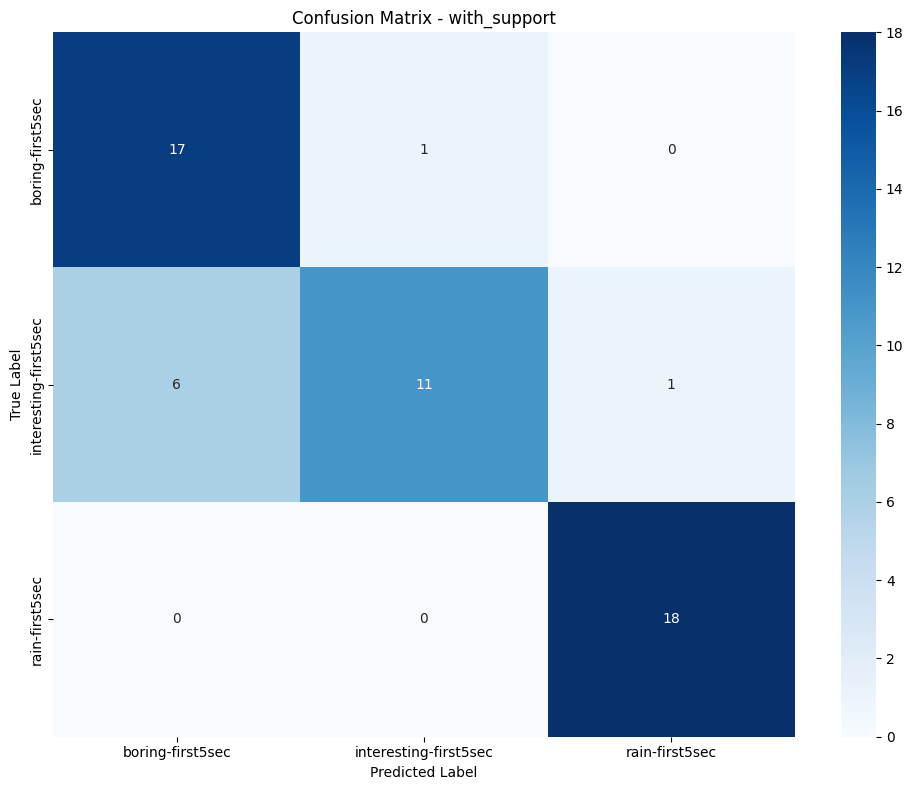

Predictions saved to /kaggle/working/predictions_with_support_first5sec.csv
Total number of files processed: 54
Overall accuracy: 0.8519

Running experiment: Transductive Inference without Support Set (First 5 Seconds)


Predicting:   0%|          | 0/2 [00:00<?, ?it/s]

Batch 0 shape: torch.Size([32, 1, 64, 313])


Predicting:  50%|█████     | 1/2 [00:01<00:01,  1.60s/it]

Batch 1 shape: torch.Size([22, 1, 64, 313])


Predicting: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]



Overall Classification Report:
                       precision    recall  f1-score   support

     boring-first5sec       0.69      1.00      0.82        18
interesting-first5sec       1.00      0.56      0.71        18
       rain-first5sec       1.00      1.00      1.00        18

             accuracy                           0.85        54
            macro avg       0.90      0.85      0.84        54
         weighted avg       0.90      0.85      0.84        54


Confusion Matrix:


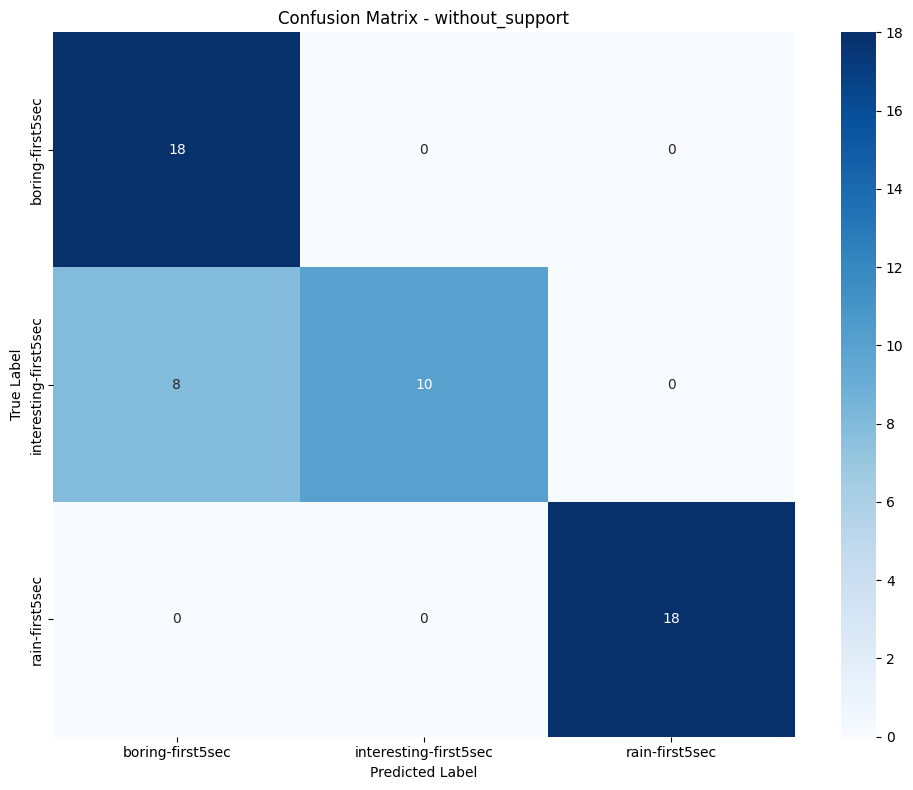

Predictions saved to /kaggle/working/predictions_without_support_first5sec.csv
Total number of files processed: 54
Overall accuracy: 0.8519

Running experiment: Without Transductive Inference (First 5 Seconds)


Predicting: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]



Overall Classification Report:
                       precision    recall  f1-score   support

     boring-first5sec       0.68      0.94      0.79        18
interesting-first5sec       0.91      0.56      0.69        18
       rain-first5sec       1.00      1.00      1.00        18

             accuracy                           0.83        54
            macro avg       0.86      0.83      0.83        54
         weighted avg       0.86      0.83      0.83        54


Confusion Matrix:


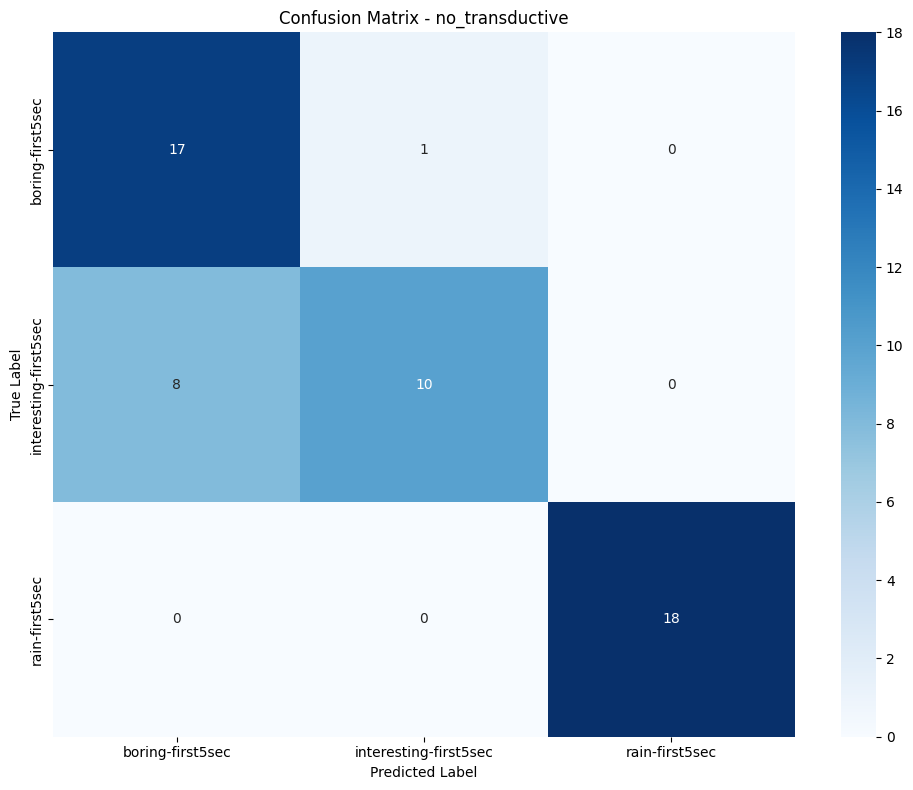

Predictions saved to /kaggle/working/predictions_no_transductive_first5sec.csv
Total number of files processed: 54
Overall accuracy: 0.8333

Ablation Study Results (First 5 Seconds):
Transductive Inference with Support Set (First 5 Seconds): Accuracy = 0.8519
Transductive Inference without Support Set (First 5 Seconds): Accuracy = 0.8519
Without Transductive Inference (First 5 Seconds): Accuracy = 0.8333


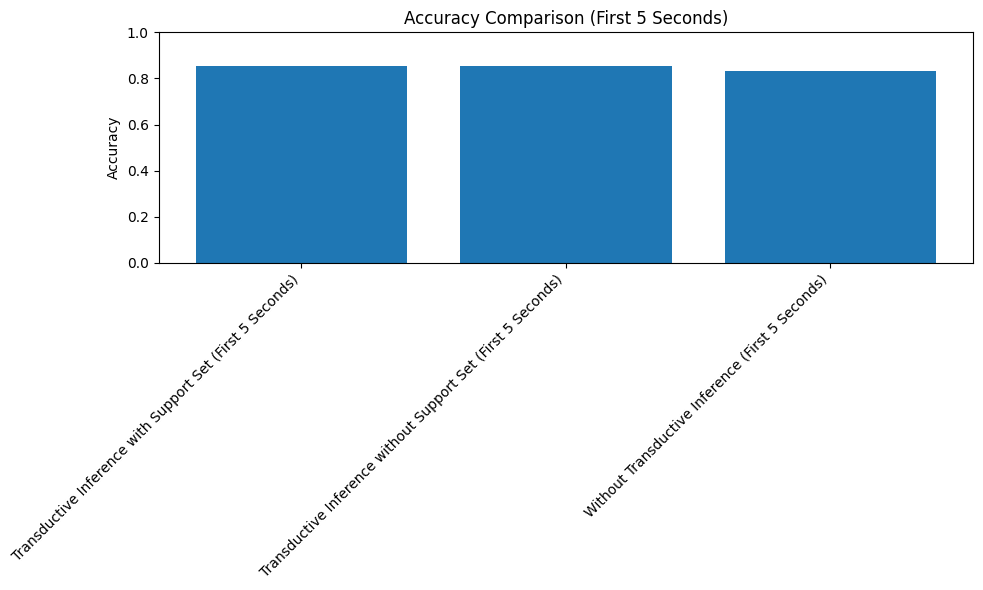

In [4]:
# Data pre-processing of audio files
class AudioPreprocessor:
    def __init__(self, target_length=5*32000, n_fft=1024, hop_length=512, n_mels=64):
        self.target_length = target_length
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=32000,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )

    def __call__(self, waveform):
        if waveform.shape[1] > self.target_length:
            start = torch.randint(0, waveform.shape[1] - self.target_length + 1, (1,)).item()
            waveform = waveform[:, start:start+self.target_length]
        else:
            waveform = F.pad(waveform, (0, self.target_length - waveform.shape[1]))
        
        # Convert to mel spectrogram
        mel_spec = self.mel_spectrogram(waveform)
        
        # Convert to decibels
        mel_spec = T.AmplitudeToDB()(mel_spec)
        
        return mel_spec 

class AudioDataset(Dataset):
    def __init__(self, root_dir, folder_names, transform=None):
        self.root_dir = root_dir
        self.folder_names = folder_names
        self.class_names = folder_names
        self.file_list = []
        self.labels = []
        self.transform = transform
        
        for label, folder in enumerate(folder_names):
            folder_path = os.path.join(root_dir, folder)
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    self.file_list.append(os.path.join(folder_path, file))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        audio_path = self.file_list[idx]
        label = self.labels[idx]
        
        try:
            waveform, sample_rate = torchaudio.load(audio_path)
            if waveform.numel() == 0:
                print(f"Warning: Empty audio file encountered: {audio_path}")
                waveform = torch.zeros(1, 32000)  # Create a dummy waveform of 1 second at 32000 Hz
            else:
                if self.transform:
                    waveform = self.transform(waveform)
        except Exception as e:
            print(f"Error loading audio file {audio_path}: {str(e)}")
            waveform = torch.zeros(1, 32000)  # Create a dummy waveform of 1 second at 32000 Hz
        
        return waveform, label, audio_path

def collate_fn(batch):
    waveforms, labels, paths = zip(*batch)
    waveforms = [waveform for waveform in waveforms if waveform.numel() > 0]
    if not waveforms:
        return torch.empty(0), torch.empty(0, dtype=torch.long), []
    waveforms_tensor = torch.stack(waveforms)
    labels_tensor = torch.tensor(labels)
    return waveforms_tensor, labels_tensor, paths

# Transductive inference
def improved_transductive_inference(model, query_set, support_set=None, support_labels=None, max_iterations=10, temperature=0.5, convergence_threshold=0.99):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        if support_set is None or support_set.numel() == 0:
            output, proto_logits, _ = model(None, None, query_set)
        else:
            output, proto_logits, _ = model(support_set, support_labels, query_set)

        if output.numel() == 0:
            print("Warning: Empty output from the model. Returning default predictions.")
            return output, torch.zeros(query_set.size(0), dtype=torch.long, device=device), torch.zeros(query_set.size(0), device=device)

        if output.dim() == 1:
            output = output.unsqueeze(0)

        pseudo_labels = output.argmax(dim=1)
        confidence = F.softmax(output / temperature, dim=1).max(dim=1)[0]

        for iteration in range(max_iterations):
            sorted_indices = confidence.argsort(descending=True)
            high_confidence_indices = sorted_indices[:max(1, len(sorted_indices) // 2)]

            if support_set is not None and support_labels is not None and support_set.numel() > 0:
                combined_set = torch.cat([support_set, query_set[high_confidence_indices]])
                combined_labels = torch.cat([support_labels, pseudo_labels[high_confidence_indices]])
            else:
                combined_set = query_set[high_confidence_indices]
                combined_labels = pseudo_labels[high_confidence_indices]

            if iteration == max_iterations - 1:  # Only update memory in the last iteration
                model.memory_module.update_memory(model.extract_features(combined_set), combined_labels)

            output, proto_logits, _ = model(combined_set, combined_labels, query_set)

            if output.numel() == 0:
                print(f"Warning: Empty output from the model at iteration {iteration}. Using previous predictions.")
                continue

            if output.dim() == 1:
                output = output.unsqueeze(0)

            new_pseudo_labels = output.argmax(dim=1)
            new_confidence = F.softmax(output / temperature, dim=1).max(dim=1)[0]

            proto_pseudo_labels = proto_logits.argmax(dim=1)
            proto_confidence = F.softmax(proto_logits / temperature, dim=1).max(dim=1)[0]

            combined_confidence = (new_confidence + proto_confidence) / 2
            combined_pseudo_labels = torch.where(new_confidence > proto_confidence, new_pseudo_labels, proto_pseudo_labels)

            update_mask = combined_confidence > confidence
            pseudo_labels[update_mask] = combined_pseudo_labels[update_mask]
            confidence[update_mask] = combined_confidence[update_mask]

            label_stability = (pseudo_labels == new_pseudo_labels).float().mean()
            if iteration > 5 and label_stability >= convergence_threshold:  # Ensure at least 5 iterations
                break

    return output, pseudo_labels, confidence

def predict_on_dataset(model, data_loader, device, support_set=None, support_labels=None):
    model.eval()
    all_predictions = []
    all_confidences = []
    all_filenames = []

    with torch.no_grad():
        for batch_idx, (batch, labels, filenames) in enumerate(tqdm(data_loader, desc="Predicting")):
            try:
                batch = batch.to(device)
                
                if batch.dim() == 3:
                    batch = batch.unsqueeze(1)  
                
                print(f"Batch {batch_idx} shape: {batch.shape}")
                
                outputs, pseudo_labels, confidence = improved_transductive_inference(
                    model, batch, support_set, support_labels
                )
                
                #print(f"Outputs shape: {outputs.shape if outputs is not None else None}")
                #print(f"Pseudo labels shape: {pseudo_labels.shape if pseudo_labels is not None else None}")
                #print(f"Confidence shape: {confidence.shape if confidence is not None else None}")
                
                if pseudo_labels is not None and confidence is not None:
                    all_predictions.extend(pseudo_labels.cpu().numpy())
                    all_confidences.extend(confidence.cpu().numpy())
                    all_filenames.extend(filenames)
                else:
                    print(f"Warning: Empty output for batch {batch_idx}")
                
            except Exception as e:
                print(f"Error processing batch {batch_idx}: {str(e)}")
                print(f"Batch shape: {batch.shape}")
                print(f"Filenames: {filenames}")
                continue

    if len(all_predictions) == 0:
        print("Warning: No valid predictions were made.")
        return [], [], []

    return all_predictions, all_confidences, all_filenames

def predict_without_transductive_inference(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_confidences = []
    all_filenames = []

    with torch.no_grad():
        for batch_idx, (batch, labels, filenames) in enumerate(tqdm(data_loader, desc="Predicting")):
            try:
                batch = batch.to(device)
                
                if batch.dim() == 3:
                    batch = batch.unsqueeze(1)  
                
                #print(f"Batch shape: {batch.shape}")  # Debug print
                
                outputs, _, _ = model(None, None, batch)
                
                if outputs.numel() == 0:
                    print(f"Warning: Empty output from the model for batch {batch_idx}. Skipping this batch.")
                    continue
                
                probabilities = F.softmax(outputs, dim=1)
                predictions = torch.argmax(probabilities, dim=1)
                confidences, _ = torch.max(probabilities, dim=1)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_confidences.extend(confidences.cpu().numpy())
                all_filenames.extend(filenames)
                
            except Exception as e:
                print(f"Error processing batch {batch_idx}: {str(e)}")
                print(f"Batch shape: {batch.shape}")
                print(f"Filenames: {filenames}")
                continue

    if len(all_predictions) == 0:
        print("Warning: No valid predictions were made.")
        return [], [], []

    return all_predictions, all_confidences, all_filenames

def run_experiment(model, data_loader, device, support_set, support_labels, experiment_type):
    if experiment_type == "with_support":
        return predict_on_dataset(model, data_loader, device, support_set, support_labels)
    elif experiment_type == "without_support":
        return predict_on_dataset(model, data_loader, device, None, None)
    elif experiment_type == "no_transductive":
        return predict_without_transductive_inference(model, data_loader, device)
    else:
        raise ValueError(f"Unknown experiment type: {experiment_type}")

def evaluate_predictions(predictions, true_labels, class_names, experiment_type):
    accuracy = sum([pred == true for pred, true in zip(predictions, true_labels)]) / len(predictions)
    
    print("\nOverall Classification Report:")
    print(classification_report(true_labels, predictions, target_names=class_names))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {experiment_type}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return accuracy


def main():
    root_dir = '/kaggle/input/datasetaudio/Sel-18'
    folder_names = ['boring-first5sec', 'interesting-first5sec', 'rain-first5sec']
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    preprocessor = AudioPreprocessor(target_length=5*32000, n_fft=1024, hop_length=512, n_mels=64)
    dataset = AudioDataset(root_dir, folder_names, transform=preprocessor)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=collate_fn)
    
    model = ImprovedDynamicFewShotClassifier(n_way=len(folder_names)).to(device)
    
    try:
        model.load_model_with_memory('/kaggle/working/final_model_with_memory.pt')
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        print("Initializing a new model.")

    support_set, support_labels = None, None
    
    # Experimental configuration
    experiments = [
        ("with_support", "Transductive Inference with Support Set (First 5 Seconds)"),
        ("without_support", "Transductive Inference without Support Set (First 5 Seconds)"),
        ("no_transductive", "Without Transductive Inference (First 5 Seconds)")
    ]
    
    results = {}
    
    for experiment_type, experiment_name in experiments:
        print(f"\nRunning experiment: {experiment_name}")
        try:
            predictions, confidences, filenames = run_experiment(model, data_loader, device, support_set, support_labels, experiment_type)
            
            if len(predictions) == 0:
                print(f"No predictions made for experiment: {experiment_name}")
                continue
            
            true_labels = [dataset.labels[dataset.file_list.index(file)] for file in filenames]
            accuracy = evaluate_predictions(predictions, true_labels, dataset.class_names, experiment_type)
            
            results[experiment_type] = {
                "accuracy": accuracy,
                "predictions": predictions,
                "confidences": confidences,
                "filenames": filenames
            }
            
            with open(f'/kaggle/working/predictions_{experiment_type}_first5sec.csv', 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(['File', 'True Class', 'Predicted Class', 'Confidence'])
                for file, true_label, prediction, confidence in zip(filenames, true_labels, predictions, confidences):
                    writer.writerow([file, dataset.class_names[true_label], dataset.class_names[prediction], confidence])
            
            print(f"Predictions saved to /kaggle/working/predictions_{experiment_type}_first5sec.csv")
            print(f"Total number of files processed: {len(predictions)}")
            print(f"Overall accuracy: {accuracy:.4f}")
        except Exception as e:
            print(f"Error in experiment {experiment_name}: {str(e)}")
            continue
    
    print("\nAblation Study Results (First 5 Seconds):")
    for experiment_type, experiment_name in experiments:
        if experiment_type in results:
            print(f"{experiment_name}: Accuracy = {results[experiment_type]['accuracy']:.4f}")
        else:
            print(f"{experiment_name}: Failed to complete")
    
    if len(results) > 0:
        plt.figure(figsize=(10, 6))
        accuracies = [results[exp_type]['accuracy'] for exp_type, _ in experiments if exp_type in results]
        plt.bar([name for exp_type, name in experiments if exp_type in results], accuracies)
        plt.title('Accuracy Comparison (First 5 Seconds)')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("No results to plot.")

if __name__ == "__main__":
    main()